# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install imutils
!pip install lungmask
!pip install efficientnet_pytorch
!pip install pydicom
!pip install --upgrade h5py
!pip install torchxrayvision
!pip install bokeh
!pip install datashader
!pip install holoviews
!pip install colorcet
!pip install umap-learn
!pip install efficientnet
import efficientnet.tfkeras as efn

from __future__ import print_function
import random
import os
import numpy as np
import cv2
import pydicom as pyd
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import skimage
import torchvision

import tensorflow as tf
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.models import load_model
from keras.utils import to_categorical

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.applications import ResNet50, ResNet152V2, DenseNet121
from keras.layers import (
    Dense,
    Dropout,
    Activation,
    Input,
    Flatten,
    Conv2D,
    MaxPooling2D,
    GlobalMaxPooling2D,
    BatchNormalization,
    GlobalAveragePooling2D,
)
from keras.optimizers import Adam
from keras.datasets import cifar10
from keras.preprocessing import image
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau
from keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)
from keras.models import load_model

from imutils import paths
from PIL import Image
from skimage import (
    io,
    color,
    exposure,
    img_as_float,
    transform,
    measure,
)
from lungmask import mask as lungmask
from collections import OrderedDict
from torchvision.models import resnet50
from efficientnet_pytorch import EfficientNet
from torchvision import transforms
from pathlib import Path

# import xrv
import torchxrayvision as xrv
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import load_model
from keras import regularizers
from keras.layers import Dropout, GlobalAveragePooling2D, Flatten, Dense
import tensorflow as tf
from tensorflow.keras.layers import Layer
import numpy as np

# xrv.datasets.XRayResizer.engine = "cv2"

!apt-get install p7zip-full
# !7z x covid_jpeg_files.zip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 78.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=16d493a8ad5fc09089b66f2ea1f2297059e1dc99e44fe59fe6ddaba4dead0c8c
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 20.7 MB/s eta 0:00:00
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━

In [ ]:
import shutil
shutil.copy("/content/drive/MyDrive/ucsd.zip", "/content/ucsd.zip")
shutil.copy("/content/drive/MyDrive/ori.zip", "/content/ori.zip")
shutil.copy("/content/drive/MyDrive/DenseNet_224_up_uncrop.h5", "/content/DenseNet_224_up_uncrop.h5")
!7z x ucsd.zip
!7z x ori.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,8 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 22471493 bytes (22 MiB)

Extracting archive: ucsd.zip
 66% 4096 Open              --
Path = ucsd.zip
Type = zip
Physical Size = 22471493

  0%     24% 1552 - ucsd/Train/Positive/VIRUS-6650710-0002.jpeg                                                        38% 2473 - __MACOSX/ucsd/Train/Positive/._VIRUS-2426822-0008.jpeg                                                                   46% 3010 - ucsd/Train/Positive/VIRUS-8121454-0001.jpeg

In [ ]:
mv "ucsd copy" "ucsd"

mv: cannot stat 'ucsd copy': No such file or directory


In [ ]:
mv "ori copy" "ori"

mv: cannot stat 'ori copy': No such file or directory


# Load Data

In [ ]:
class JPEGToNumpy():
    def __call__(self, sample):
        #print("Check Point 1")
        imagenet_mean = np.array([0.485, 0.456, 0.406])
        imagenet_std = np.array([0.229, 0.224, 0.225])
        img = image.load_img(sample['jpeg_path'], target_size=(224, 224),
                             color_mode='rgb', interpolation='lanczos')
        img_array = np.asarray(img, dtype='uint8')
        img_array =  img_array / 255
        centered = np.subtract(img_array, imagenet_mean)
        standardized = np.divide(centered, imagenet_std)
        sample['image'] = img_array
        return sample

class AiSeverity:
    def __init__(self, device=None):
        self.transforms = transforms.Compose([
            JPEGToNumpy(),
            # CreateLungMask(device),
            # ApplyLungMask(constant_values=-1024)
        ])

    def __call__(self, jpeg_path):
        sample = {'jpeg_path': jpeg_path}
        sample = self.transforms(sample)
        return sample['image']

# Folder paths
normal_folder = 'ori/Train/Negative/'
pneumonia_folder = 'ori/Train/Positive/'
# Initialize an empty dictionary to store file names and labels
file_labels = {}
file_samples = {}

# Set the random seed for reproducibility
np.random.seed(100)

# Assign labels to PNEUMONIA files
pneumonia_files = os.listdir(pneumonia_folder)
for file_name in pneumonia_files:
    file_path = os.path.join(pneumonia_folder, file_name)
    file_labels[file_path] = 1

# Assign labels to NORMAL files
normal_files = os.listdir(normal_folder)
for file_name in normal_files:
    file_path = os.path.join(normal_folder, file_name)
    file_labels[file_path] = 0

# Call AiSeverity method
ai_severity = AiSeverity(device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
index = 0
items_list = list(file_labels.items())

# Shuffle the list of tuples using random.shuffle()
np.random.shuffle(items_list)

# Create a new dictionary from the shuffled list of tuples
file_labels = dict(items_list)

for file_path, label in file_labels.items():
    sample = ai_severity(file_path)
    print(f'{file_path}: label is {label}')
    file_samples[file_path] = sample
    index = index + 1
    print(f"Index: {index}")

train_samples = file_samples
train_labels = file_labels

# Folder paths
normal_folder = 'ori/Validation/Negative/'
pneumonia_folder = 'ori/Validation/Positive/'
# Initialize an empty dictionary to store file names and labels
file_labels = {}
file_samples = {}

# Set the random seed for reproducibility
np.random.seed(100)

# Assign labels to PNEUMONIA files
pneumonia_files = os.listdir(pneumonia_folder)
for file_name in pneumonia_files:
    file_path = os.path.join(pneumonia_folder, file_name)
    file_labels[file_path] = 1

# Assign labels to NORMAL files
normal_files = os.listdir(normal_folder)
for file_name in normal_files:
    file_path = os.path.join(normal_folder, file_name)
    file_labels[file_path] = 0

# Call AiSeverity method
ai_severity = AiSeverity(device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
index = 0
items_list = list(file_labels.items())

# Shuffle the list of tuples using random.shuffle()
np.random.shuffle(items_list)

# Create a new dictionary from the shuffled list of tuples
file_labels = dict(items_list)

for file_path, label in file_labels.items():
    sample = ai_severity(file_path)
    print(f'{file_path}: label is {label}')
    file_samples[file_path] = sample
    index = index + 1
    print(f"Index: {index}")

validation_samples = file_samples
validation_labels = file_labels

# Folder paths
normal_folder = 'ori/Test/Negative/'
pneumonia_folder = 'ori/Test/Positive/'

# Initialize an empty dictionary to store file names and labels
file_labels = {}
file_samples = {}

# Assign labels to PNEUMONIA files
pneumonia_files = os.listdir(pneumonia_folder)
for file_name in pneumonia_files:
    file_path = os.path.join(pneumonia_folder, file_name)
    file_labels[file_path] = 1

# Assign labels to NORMAL files
normal_files = os.listdir(normal_folder)
for file_name in normal_files:
    file_path = os.path.join(normal_folder, file_name)
    file_labels[file_path] = 0

# Call AiSeverity method
ai_severity = AiSeverity(device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
index = 0
items_list = list(file_labels.items())

# Shuffle the list of tuples using random.shuffle()
np.random.shuffle(items_list)

# Create a new dictionary from the shuffled list of tuples
file_labels = dict(items_list)

for file_path, label in file_labels.items():
    sample = ai_severity(file_path)
    print(f'{file_path}: label is {label}')
    file_samples[file_path] = sample
    index = index + 1
    print(f"Index: {index}")

test_samples = file_samples
test_labels = file_labels

BATCH_SIZE_TRAINING = 64
BATCH_SIZE_VALIDATION = 64
BATCH_SIZE_TESTING = 1

train_datagen = ImageDataGenerator(
fill_mode="nearest",
    validation_split=0.20,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,

)

test_datagen = ImageDataGenerator(
fill_mode="nearest",
    validation_split=0.20,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
)

train_image_list = [(train_samples[key], train_labels[key]) for key in train_samples.keys()]
validation_image_list = [(validation_samples[key], validation_labels[key]) for key in validation_samples.keys()]
test_image_list = [(test_samples[key], test_labels[key]) for key in test_samples.keys()]

# Split the image_list into training and validation sets
train_generator_test = train_datagen.flow(
    x=np.array([image for image, label in train_image_list]),
    y=[label for image, label in train_image_list],
    batch_size=BATCH_SIZE_TRAINING,
    shuffle=True,
    seed=60
)

valid_generator_test = train_datagen.flow(
    x=np.array([image for image, label in validation_image_list]),
    y=[label for image, label in validation_image_list],
    batch_size=BATCH_SIZE_VALIDATION,
    shuffle=True,
    seed=60
)

test_generator_test = test_datagen.flow(
    x=np.array([image for image, label in test_image_list]),
    y=[label for image, label in test_image_list],
    batch_size=BATCH_SIZE_TESTING,
    shuffle=False,
    seed=60
)


ori/Train/Negative/2RLP16V2F1LM.png: label is 0
Index: 1
ori/Train/Negative/B1X1MRK79EY9.png: label is 0
Index: 2
ori/Train/Negative/IB786XGIALB8.png: label is 0
Index: 3
ori/Train/Negative/JP7QAHMOLD48.png: label is 0
Index: 4
ori/Train/Negative/HNFWEFYK47QM.png: label is 0
Index: 5
ori/Train/Positive/3G6K356MXQY6.png: label is 1
Index: 6
ori/Train/Positive/7SDFNEBV7FVE.png: label is 1
Index: 7
ori/Train/Positive/0H8RJNXOB5M2.png: label is 1
Index: 8
ori/Train/Negative/BFMCFT7TDRBJ.png: label is 0
Index: 9
ori/Train/Negative/361T522Z17KP.png: label is 0
Index: 10
ori/Train/Negative/G8IHGG17O6LZ.png: label is 0
Index: 11
ori/Train/Positive/0NC27JBIYJTJ.png: label is 1
Index: 12
ori/Train/Positive/F78RBE54CB2H.png: label is 1
Index: 13
ori/Train/Negative/5M163NLP06AL.png: label is 0
Index: 14
ori/Train/Positive/DN6OJ08Q220H.png: label is 1
Index: 15
ori/Train/Positive/7ERIUJG8LB88.png: label is 1
Index: 16
ori/Train/Positive/1FZ8J4YXJDX1.png: label is 1
Index: 17
ori/Train/Negative/4SVC

In [ ]:
class JPEGToNumpy():
    def __call__(self, sample):
        #print("Check Point 1")
        imagenet_mean = np.array([0.485, 0.456, 0.406])
        imagenet_std = np.array([0.229, 0.224, 0.225])
        img = image.load_img(sample['jpeg_path'], target_size=(224, 224),
                             color_mode='rgb', interpolation='lanczos')
        img_array = np.asarray(img, dtype='uint8')
        img_array =  img_array / 255
        centered = np.subtract(img_array, imagenet_mean)
        standardized = np.divide(centered, imagenet_std)
        sample['image'] = img_array
        return sample

class AiSeverity:
    def __init__(self, device=None):
        self.transforms = transforms.Compose([
            JPEGToNumpy(),
            # CreateLungMask(device),
            # ApplyLungMask(constant_values=-1024)
        ])

    def __call__(self, jpeg_path):
        sample = {'jpeg_path': jpeg_path}
        sample = self.transforms(sample)
        return sample['image']

# Folder paths
normal_folder = 'ucsd/Train/Negative/'
pneumonia_folder = 'ucsd/Train/Positive/'
# Initialize an empty dictionary to store file names and labels
file_labels = {}
file_samples = {}

# Set the random seed for reproducibility
np.random.seed(100)

# Assign labels to PNEUMONIA files
pneumonia_files = os.listdir(pneumonia_folder)
for file_name in pneumonia_files:
    file_path = os.path.join(pneumonia_folder, file_name)
    file_labels[file_path] = 1

# Assign labels to NORMAL files
normal_files = os.listdir(normal_folder)
for file_name in normal_files:
    file_path = os.path.join(normal_folder, file_name)
    file_labels[file_path] = 0

# Call AiSeverity method
ai_severity = AiSeverity(device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
index = 0
items_list = list(file_labels.items())

# Shuffle the list of tuples using random.shuffle()
np.random.shuffle(items_list)

# Create a new dictionary from the shuffled list of tuples
file_labels = dict(items_list)

for file_path, label in file_labels.items():
    sample = ai_severity(file_path)
    print(f'{file_path}: label is {label}')
    file_samples[file_path] = sample
    index = index + 1
    print(f"Index: {index}")

train_samples = file_samples
train_labels = file_labels

# Folder paths
normal_folder = 'ucsd/Validation/Negative/'
pneumonia_folder = 'ucsd/Validation/Positive/'
# Initialize an empty dictionary to store file names and labels
file_labels = {}
file_samples = {}

# Set the random seed for reproducibility
np.random.seed(100)

# Assign labels to PNEUMONIA files
pneumonia_files = os.listdir(pneumonia_folder)
for file_name in pneumonia_files:
    file_path = os.path.join(pneumonia_folder, file_name)
    file_labels[file_path] = 1

# Assign labels to NORMAL files
normal_files = os.listdir(normal_folder)
for file_name in normal_files:
    file_path = os.path.join(normal_folder, file_name)
    file_labels[file_path] = 0

# Call AiSeverity method
ai_severity = AiSeverity(device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
index = 0
items_list = list(file_labels.items())

# Shuffle the list of tuples using random.shuffle()
np.random.shuffle(items_list)

# Create a new dictionary from the shuffled list of tuples
file_labels = dict(items_list)

for file_path, label in file_labels.items():
    sample = ai_severity(file_path)
    print(f'{file_path}: label is {label}')
    file_samples[file_path] = sample
    index = index + 1
    print(f"Index: {index}")

validation_samples = file_samples
validation_labels = file_labels

# Folder paths
normal_folder = 'ucsd/Test/Negative/'
pneumonia_folder = 'ucsd/Test/Positive/'

# Initialize an empty dictionary to store file names and labels
file_labels = {}
file_samples = {}

# Assign labels to PNEUMONIA files
pneumonia_files = os.listdir(pneumonia_folder)
for file_name in pneumonia_files:
    file_path = os.path.join(pneumonia_folder, file_name)
    file_labels[file_path] = 1

# Assign labels to NORMAL files
normal_files = os.listdir(normal_folder)
for file_name in normal_files:
    file_path = os.path.join(normal_folder, file_name)
    file_labels[file_path] = 0

# Call AiSeverity method
ai_severity = AiSeverity(device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
index = 0
items_list = list(file_labels.items())

# Shuffle the list of tuples using random.shuffle()
np.random.shuffle(items_list)

# Create a new dictionary from the shuffled list of tuples
file_labels = dict(items_list)

for file_path, label in file_labels.items():
    sample = ai_severity(file_path)
    print(f'{file_path}: label is {label}')
    file_samples[file_path] = sample
    index = index + 1
    print(f"Index: {index}")

test_samples = file_samples
test_labels = file_labels

BATCH_SIZE_TRAINING = 64
BATCH_SIZE_VALIDATION = 64
BATCH_SIZE_TESTING = 1

train_datagen = ImageDataGenerator(
fill_mode="nearest",
    validation_split=0.20,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,

)

test_datagen = ImageDataGenerator(
fill_mode="nearest",
    validation_split=0.20,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
)

train_image_list = [(train_samples[key], train_labels[key]) for key in train_samples.keys()]
validation_image_list = [(validation_samples[key], validation_labels[key]) for key in validation_samples.keys()]
test_image_list = [(test_samples[key], test_labels[key]) for key in test_samples.keys()]

# Split the image_list into training and validation sets
train_generator = train_datagen.flow(
    x=np.array([image for image, label in train_image_list]),
    y=[label for image, label in train_image_list],
    batch_size=BATCH_SIZE_TRAINING,
    shuffle=True,
    seed=60
)

valid_generator = train_datagen.flow(
    x=np.array([image for image, label in validation_image_list]),
    y=[label for image, label in validation_image_list],
    batch_size=BATCH_SIZE_VALIDATION,
    shuffle=True,
    seed=60
)

test_generator = test_datagen.flow(
    x=np.array([image for image, label in test_image_list]),
    y=[label for image, label in test_image_list],
    batch_size=BATCH_SIZE_TESTING,
    shuffle=False,
    seed=60
)

Streaming output truncated to the last 5000 lines.
ucsd/Train/Positive/VIRUS-603658-0002.jpeg: label is 1
Index: 577
ucsd/Train/Negative/NORMAL-9033279-0002.jpeg: label is 0
Index: 578
ucsd/Train/Positive/VIRUS-1657437-0003.jpeg: label is 1
Index: 579
ucsd/Train/Positive/VIRUS-8078959-0001.jpeg: label is 1
Index: 580
ucsd/Train/Positive/VIRUS-8550080-0001.jpeg: label is 1
Index: 581
ucsd/Train/Negative/NORMAL-8644314-0001.jpeg: label is 0
Index: 582
ucsd/Train/Negative/NORMAL-9543520-0001.jpeg: label is 0
Index: 583
ucsd/Train/Positive/VIRUS-1851402-0002.jpeg: label is 1
Index: 584
ucsd/Train/Positive/VIRUS-9476607-0001.jpeg: label is 1
Index: 585
ucsd/Train/Positive/VIRUS-3451166-0003.jpeg: label is 1
Index: 586
ucsd/Train/Positive/VIRUS-1076722-0003.jpeg: label is 1
Index: 587
ucsd/Train/Positive/VIRUS-9496210-0005.jpeg: label is 1
Index: 588
ucsd/Train/Positive/VIRUS-2897609-0003.jpeg: label is 1
Index: 589
ucsd/Train/Positive/VIRUS-7435285-0006.jpeg: label is 1
Index: 590
ucsd/Trai

# Visualize

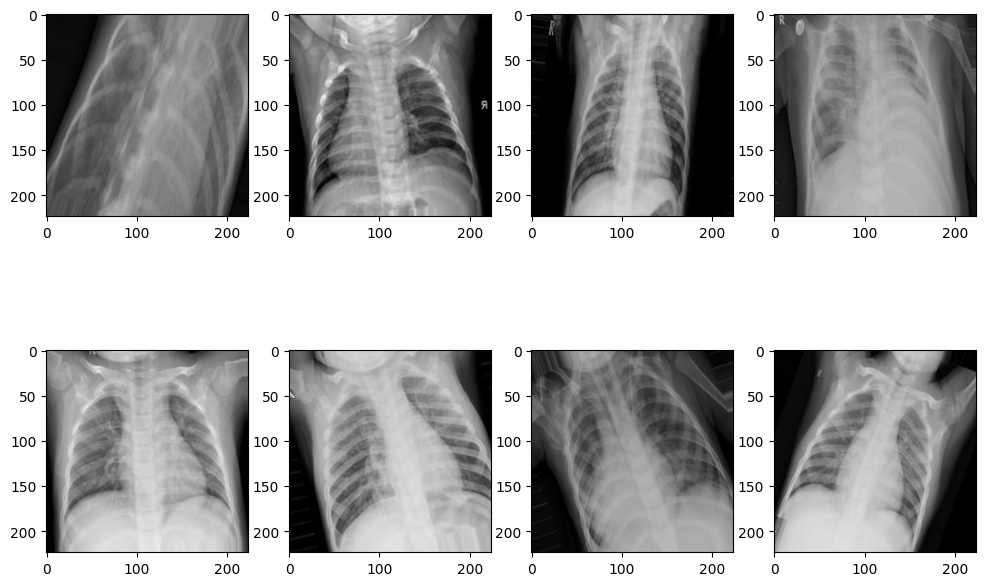

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 4, 1)
plt.imshow(train_generator[0][0][0,:,:,:])
plt.subplot(2, 4, 2)
plt.imshow(valid_generator[0][0][0,:,:,:])
plt.subplot(2, 4, 3)
plt.imshow(test_generator[0][0][0,:,:,:])
plt.subplot(2, 4, 4)
plt.imshow(train_generator[0][0][30,:,:,:])
plt.subplot(2, 4, 5)
plt.imshow(valid_generator[0][0][30,:,:,:])
plt.subplot(2, 4, 6)
plt.imshow(test_generator[5][0][0,:,:,:])
plt.subplot(2, 4, 7)
plt.imshow(train_generator[6][0][40,:,:,:])
plt.subplot(2, 4, 8)
plt.imshow(test_generator[6][0][0,:,:,:])
plt.show()

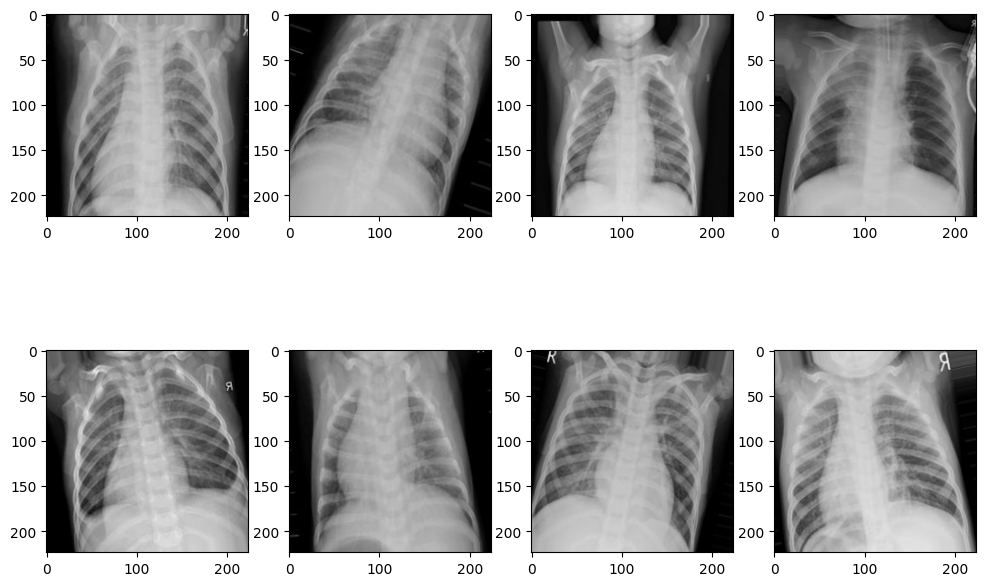

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 4, 1)
plt.imshow(train_generator[8][0][0,:,:,:])
plt.subplot(2, 4, 2)
plt.imshow(valid_generator[2][0][0,:,:,:])
plt.subplot(2, 4, 3)
plt.imshow(test_generator[6][0][0,:,:,:])
plt.subplot(2, 4, 4)
plt.imshow(train_generator[4][0][30,:,:,:])
plt.subplot(2, 4, 5)
plt.imshow(valid_generator[1][0][1,:,:,:])
plt.subplot(2, 4, 6)
plt.imshow(test_generator[3][0][0,:,:,:])
plt.subplot(2, 4, 7)
plt.imshow(train_generator[4][0][40,:,:,:])
plt.subplot(2, 4, 8)
plt.imshow(test_generator[5][0][0,:,:,:])
plt.show()

# Basic Transfer Learning 0

In [ ]:
img_size = 224
dropout = 0
weights = "DenseNet_224_up_uncrop.h5"

In [ ]:
base_model = DenseNet121(weights=None, include_top=False,
                                 input_shape = (img_size,img_size,3))
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0)(x)
predictions = layers.Dense(1, activation='sigmoid', name='last')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.load_weights(weights)
num_layers_to_freeze = 300  # You can adjust this fraction as needed
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dropout(dropout)(x)
x = layers.Dense(128, activation='relu',)(x)
x = layers.Dropout(dropout)(x)
predictions= layers.Dense(1, activation='sigmoid',name='last')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
import tensorflow.keras.backend as K
print("Compiling the model...")
def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[0] ** (1 - y_true)) * (weights[1] ** y_true) * K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss
opt = Adam(lr=1e-5)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy","AUC","Precision","Recall"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

Compiling the model...


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 3)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [ ]:
# train the head of the network
print("training the head...")
history = model.fit(
        train_generator,
        epochs = 25,
        validation_data=valid_generator,
        callbacks=[cb_checkpointer,learning_rate_reduction,cb_early_stopper],
)
# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(history.history)

training the head...
Epoch 1/25
31/31 [==============================] - 75s 1s/step - loss: 0.4372 - accuracy: 0.8231 - auc: 0.8998 - precision: 0.8361 - recall: 0.7906 - val_loss: 0.4683 - val_accuracy: 0.7566 - val_auc: 0.9568 - val_precision: 0.9837 - val_recall: 0.5063 - lr: 0.0010
Epoch 2/25
31/31 [==============================] - 33s 1s/step - loss: 0.2396 - accuracy: 0.9151 - auc: 0.9641 - precision: 0.9139 - recall: 0.9110 - val_loss: 0.3521 - val_accuracy: 0.8600 - val_auc: 0.9698 - val_precision: 0.9775 - val_recall: 0.7280 - lr: 0.0010
Epoch 3/25
31/31 [==============================] - 30s 954ms/step - loss: 0.2023 - accuracy: 0.9227 - auc: 0.9736 - precision: 0.9204 - recall: 0.9204 - val_loss: 0.4531 - val_accuracy: 0.8012 - val_auc: 0.9793 - val_precision: 0.9862 - val_recall: 0.5983 - lr: 0.0010
Epoch 4/25
31/31 [==============================] - 34s 1s/step - loss: 0.1782 - accuracy: 0.9329 - auc: 0.9790 - precision: 0.9327 - recall: 0.9288 - val_loss: 0.3470 - val_a

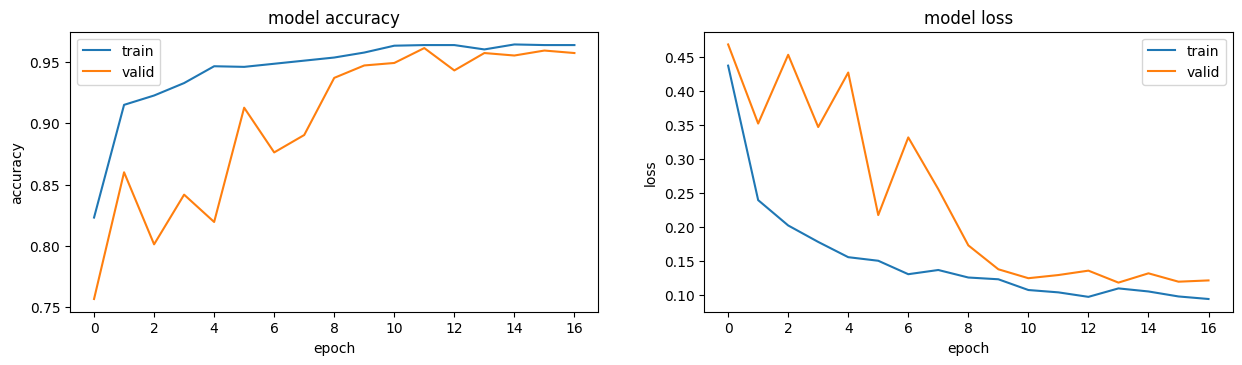

In [ ]:
plt.figure(1, figsize = (15,8))
plt.subplot(221)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.subplot(222)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

In [ ]:
test_generator.reset()
prediction = model.predict(test_generator)
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator)):
    batch_images, batch_labels = test_generator.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(prediction))

616/616 [==============================] - 55s 85ms/step


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.9594155844155844
0.9589536098245467
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       317
           1       0.97      0.94      0.96       299

    accuracy                           0.96       616
   macro avg       0.96      0.96      0.96       616
weighted avg       0.96      0.96      0.96       616



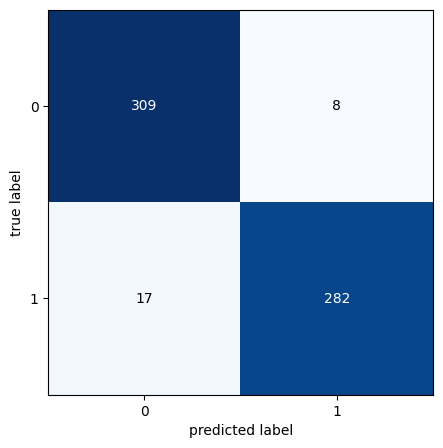

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
y_test = labels
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))
plt.show()

In [ ]:
model_save_path = '/content/drive/My Drive/your_folder/"ori_one_fold_basic_transfer_0_0.h5"'
model.save(model_save_path)

165/165 [==============================] - 8s 47ms/step
(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.6181818181818182
0.6126543209876543
              precision    recall  f1-score   support

           0       0.58      0.92      0.71        84
           1       0.78      0.31      0.44        81

    accuracy                           0.62       165
   macro avg       0.68      0.61      0.58       165
weighted avg       0.68      0.62      0.58       165



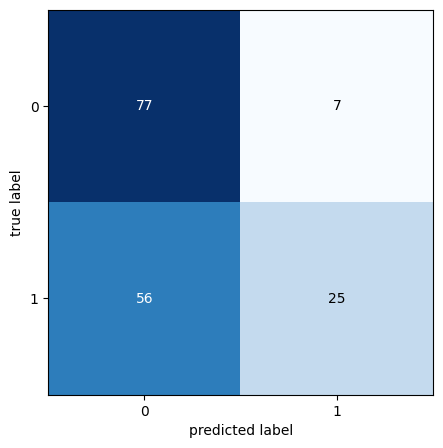

In [ ]:
train_generator_test.reset()
valid_generator_test.reset()
test_generator_test.reset()
combined_prediction = []
combined_prediction.extend(model.predict(test_generator_test))
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator_test)):
    batch_images, batch_labels = test_generator_test.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(combined_prediction))
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
y_test = labels.T
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))

# Basic Transfer Learning 0.3

In [ ]:
img_size = 224
dropout = 0.3
weights = "DenseNet_224_up_uncrop.h5"

In [ ]:
base_model = DenseNet121(weights=None, include_top=False,
                                 input_shape = (img_size,img_size,3))
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0)(x)
predictions = layers.Dense(1, activation='sigmoid', name='last')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.load_weights(weights)
num_layers_to_freeze = 300  # You can adjust this fraction as needed
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dropout(dropout)(x)
x = layers.Dense(128, activation='relu',)(x)
x = layers.Dropout(dropout)(x)
predictions= layers.Dense(1, activation='sigmoid',name='last')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
import tensorflow.keras.backend as K
print("Compiling the model...")
def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[0] ** (1 - y_true)) * (weights[1] ** y_true) * K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss
opt = Adam(lr=1e-5)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy","AUC","Precision","Recall"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

Compiling the model...


In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 230, 230, 3)          0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 3)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [ ]:
# train the head of the network
print("training the head...")
history = model.fit(
        train_generator,
        epochs = 25,
        validation_data=valid_generator,
        callbacks=[cb_checkpointer,learning_rate_reduction,cb_early_stopper],
)
# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(history.history)

training the head...
Epoch 1/25
31/31 [==============================] - 54s 1s/step - loss: 0.4700 - accuracy: 0.7672 - auc: 0.8588 - precision: 0.7669 - recall: 0.7476 - val_loss: 0.3068 - val_accuracy: 0.8986 - val_auc: 0.9604 - val_precision: 0.9056 - val_recall: 0.8828 - lr: 0.0010
Epoch 2/25
31/31 [==============================] - 33s 1s/step - loss: 0.2849 - accuracy: 0.8841 - auc: 0.9498 - precision: 0.8830 - recall: 0.8775 - val_loss: 0.3514 - val_accuracy: 0.8398 - val_auc: 0.9703 - val_precision: 0.9762 - val_recall: 0.6862 - lr: 0.0010
Epoch 3/25
31/31 [==============================] - ETA: 0s - loss: 0.2290 - accuracy: 0.9166 - auc: 0.9668 - precision: 0.9090 - recall: 0.9204
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
31/31 [==============================] - 33s 1s/step - loss: 0.2290 - accuracy: 0.9166 - auc: 0.9668 - precision: 0.9090 - recall: 0.9204 - val_loss: 0.3991 - val_accuracy: 0.8093 - val_auc: 0.9769 - val_precision: 0.9866 - 

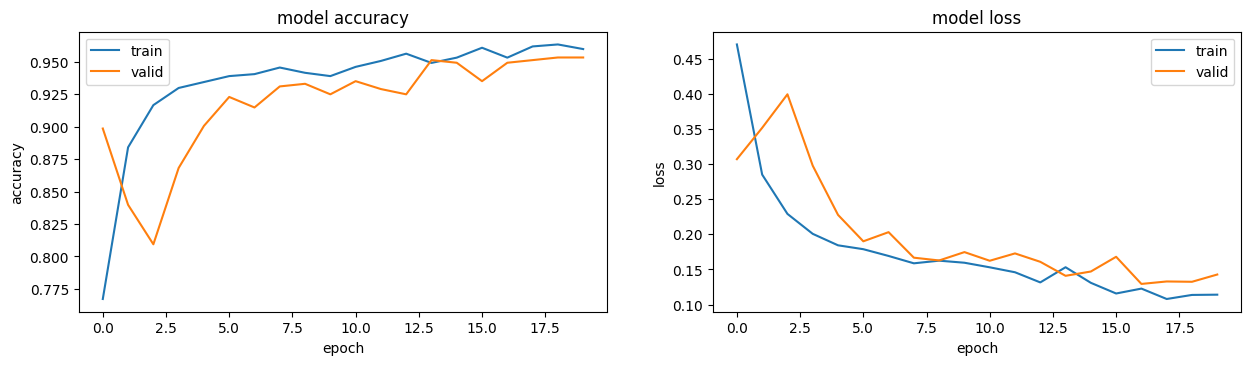

In [ ]:
plt.figure(1, figsize = (15,8))
plt.subplot(221)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.subplot(222)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

In [ ]:
test_generator.reset()
prediction = model.predict(test_generator)
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator)):
    batch_images, batch_labels = test_generator.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(prediction))

616/616 [==============================] - 32s 48ms/step


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.948051948051948
0.947342877942247
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       317
           1       0.97      0.92      0.95       299

    accuracy                           0.95       616
   macro avg       0.95      0.95      0.95       616
weighted avg       0.95      0.95      0.95       616



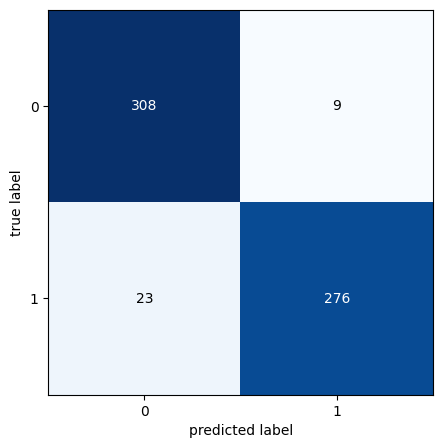

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
y_test = labels
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))
plt.show()

In [ ]:
model_save_path = '/content/drive/My Drive/your_folder/"ori_one_fold_basic_transfer_0_0.h5"'
model.save(model_save_path)

165/165 [==============================] - 3s 18ms/step
(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.6
0.5934744268077601
              precision    recall  f1-score   support

           0       0.56      0.95      0.71        84
           1       0.83      0.23      0.37        81

    accuracy                           0.60       165
   macro avg       0.69      0.59      0.54       165
weighted avg       0.69      0.60      0.54       165



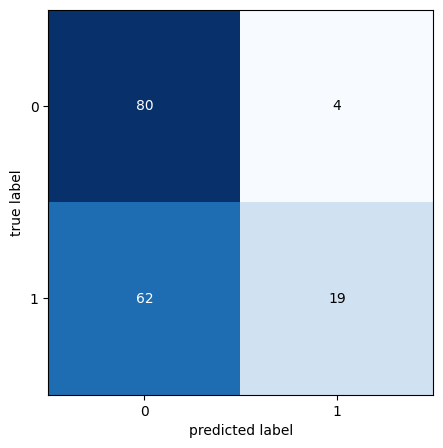

In [ ]:
train_generator_test.reset()
valid_generator_test.reset()
test_generator_test.reset()
combined_prediction = []
combined_prediction.extend(model.predict(test_generator_test))
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator_test)):
    batch_images, batch_labels = test_generator_test.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(combined_prediction))
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
y_test = labels.T
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))

# Basic Transfer Learning 0.6

In [ ]:
img_size = 224
dropout = 0.6
weights = "DenseNet_224_up_uncrop.h5"

In [ ]:
base_model = DenseNet121(weights=None, include_top=False,
                                 input_shape = (img_size,img_size,3))
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0)(x)
predictions = layers.Dense(1, activation='sigmoid', name='last')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.load_weights(weights)
num_layers_to_freeze = 300  # You can adjust this fraction as needed
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dropout(dropout)(x)
x = layers.Dense(128, activation='relu',)(x)
x = layers.Dropout(dropout)(x)
predictions= layers.Dense(1, activation='sigmoid',name='last')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
import tensorflow.keras.backend as K
print("Compiling the model...")
def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[0] ** (1 - y_true)) * (weights[1] ** y_true) * K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss
opt = Adam(lr=1e-5)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy","AUC","Precision","Recall"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
model.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 3)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [ ]:
# train the head of the network
print("training the head...")
history = model.fit(
        train_generator,
        epochs = 25,
        validation_data=valid_generator,
        callbacks=[cb_checkpointer,learning_rate_reduction,cb_early_stopper],
)
# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(history.history)

training the head...
Epoch 1/25
31/31 [==============================] - 72s 1s/step - loss: 0.6241 - accuracy: 0.6518 - auc: 0.7117 - precision: 0.6471 - recall: 0.6220 - val_loss: 0.5016 - val_accuracy: 0.6998 - val_auc: 0.9517 - val_precision: 0.9789 - val_recall: 0.3891 - lr: 0.0010
Epoch 2/25
31/31 [==============================] - 28s 889ms/step - loss: 0.3701 - accuracy: 0.8424 - auc: 0.9190 - precision: 0.8494 - recall: 0.8209 - val_loss: 0.5709 - val_accuracy: 0.7566 - val_auc: 0.9595 - val_precision: 1.0000 - val_recall: 0.4979 - lr: 0.0010
Epoch 3/25
31/31 [==============================] - ETA: 0s - loss: 0.2781 - accuracy: 0.8958 - auc: 0.9535 - precision: 0.8923 - recall: 0.8932
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
31/31 [==============================] - 28s 908ms/step - loss: 0.2781 - accuracy: 0.8958 - auc: 0.9535 - precision: 0.8923 - recall: 0.8932 - val_loss: 0.7287 - val_accuracy: 0.7039 - val_auc: 0.9707 - val_precision: 1.0

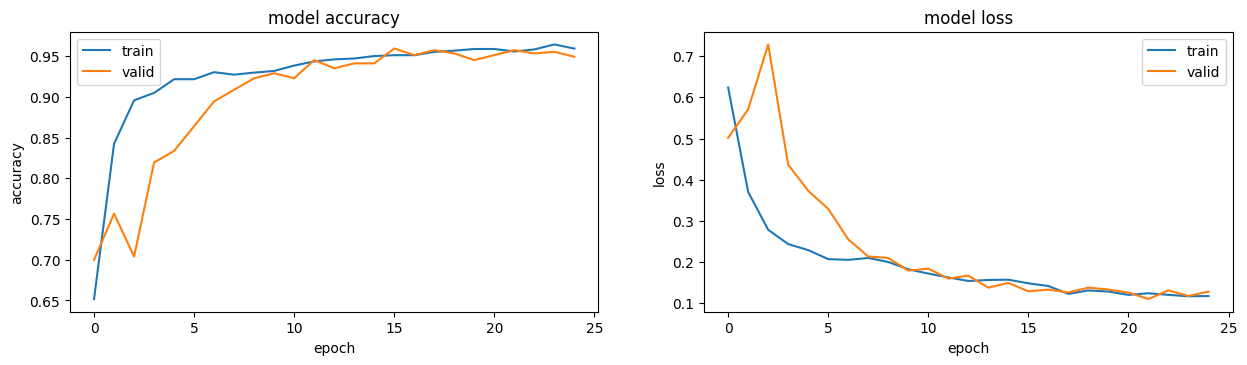

In [ ]:
plt.figure(1, figsize = (15,8))
plt.subplot(221)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.subplot(222)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

In [ ]:
test_generator.reset()
prediction = model.predict(test_generator)
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator)):
    batch_images, batch_labels = test_generator.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(prediction))

616/616 [==============================] - 15s 19ms/step


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.9561688311688312
0.9557040819556248
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       317
           1       0.97      0.94      0.95       299

    accuracy                           0.96       616
   macro avg       0.96      0.96      0.96       616
weighted avg       0.96      0.96      0.96       616



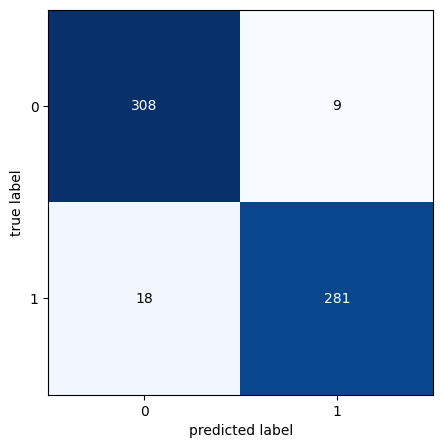

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
y_test = labels
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))
plt.show()

In [ ]:
model_save_path = '/content/drive/My Drive/your_folder/"ori_one_fold_basic_transfer_0_0.h5"'
model.save(model_save_path)

165/165 [==============================] - 3s 18ms/step
(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.6363636363636364
0.6305114638447972
              precision    recall  f1-score   support

           0       0.59      0.95      0.73        84
           1       0.86      0.31      0.45        81

    accuracy                           0.64       165
   macro avg       0.73      0.63      0.59       165
weighted avg       0.72      0.64      0.59       165



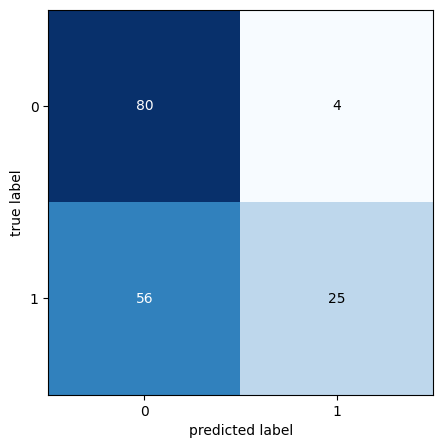

In [ ]:
train_generator_test.reset()
valid_generator_test.reset()
test_generator_test.reset()
combined_prediction = []
combined_prediction.extend(model.predict(test_generator_test))
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator_test)):
    batch_images, batch_labels = test_generator_test.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(combined_prediction))
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
y_test = labels.T
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))

# Basic Transfer Learning 0.9

In [ ]:
img_size = 224
dropout = 0.9
weights = "DenseNet_224_up_uncrop.h5"

In [ ]:
base_model = DenseNet121(weights=None, include_top=False,
                                 input_shape = (img_size,img_size,3))
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0)(x)
predictions = layers.Dense(1, activation='sigmoid', name='last')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.load_weights(weights)
num_layers_to_freeze = 300  # You can adjust this fraction as needed
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dropout(dropout)(x)
x = layers.Dense(128, activation='relu',)(x)
x = layers.Dropout(dropout)(x)
predictions= layers.Dense(1, activation='sigmoid',name='last')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
import tensorflow.keras.backend as K
print("Compiling the model...")
def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[0] ** (1 - y_true)) * (weights[1] ** y_true) * K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss
opt = Adam(lr=1e-5)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy","AUC","Precision","Recall"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

Compiling the model...


In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 230, 230, 3)          0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 3)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [ ]:
# train the head of the network
print("training the head...")
history = model.fit(
        train_generator,
        epochs = 25,
        validation_data=valid_generator,
        callbacks=[cb_checkpointer,learning_rate_reduction,cb_early_stopper],
)
# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(history.history)

training the head...
Epoch 1/25
31/31 [==============================] - 52s 1s/step - loss: 1.6707 - accuracy: 0.4835 - auc: 0.4749 - precision: 0.4681 - recall: 0.4691 - val_loss: 0.6904 - val_accuracy: 0.5294 - val_auc: 0.5926 - val_precision: 0.5778 - val_recall: 0.1088 - lr: 0.0010
Epoch 2/25
31/31 [==============================] - 28s 900ms/step - loss: 1.0879 - accuracy: 0.5236 - auc: 0.5293 - precision: 0.5103 - recall: 0.4660 - val_loss: 0.6935 - val_accuracy: 0.4848 - val_auc: 0.5376 - val_precision: 0.4848 - val_recall: 1.0000 - lr: 0.0010
Epoch 3/25
31/31 [==============================] - ETA: 0s - loss: 0.8440 - accuracy: 0.5267 - auc: 0.5426 - precision: 0.5113 - recall: 0.5665
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
31/31 [==============================] - 28s 899ms/step - loss: 0.8440 - accuracy: 0.5267 - auc: 0.5426 - precision: 0.5113 - recall: 0.5665 - val_loss: 0.6930 - val_accuracy: 0.4848 - val_auc: 0.6946 - val_precision: 0.4

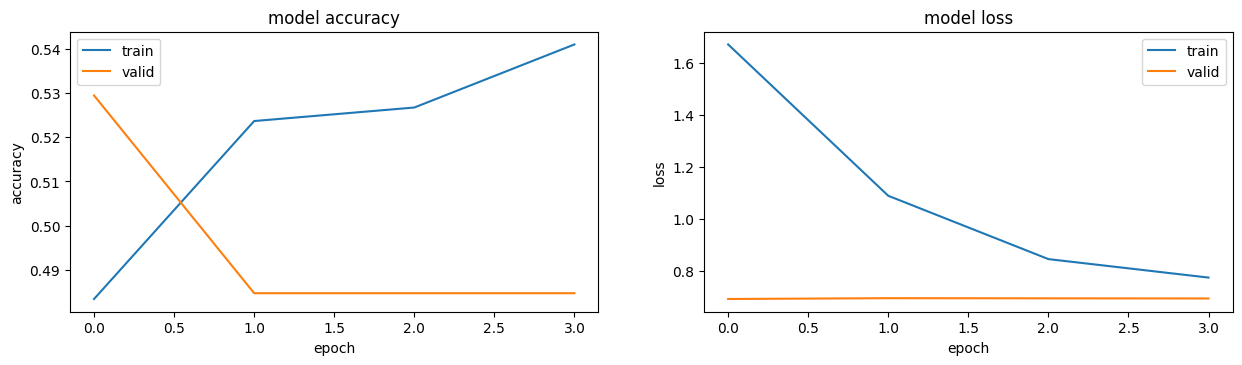

In [ ]:
plt.figure(1, figsize = (15,8))
plt.subplot(221)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.subplot(222)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

In [ ]:
test_generator.reset()
prediction = model.predict(test_generator)
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator)):
    batch_images, batch_labels = test_generator.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(prediction))

616/616 [==============================] - 15s 18ms/step


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.48538961038961037
0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       317
           1       0.49      1.00      0.65       299

    accuracy                           0.49       616
   macro avg       0.24      0.50      0.33       616
weighted avg       0.24      0.49      0.32       616



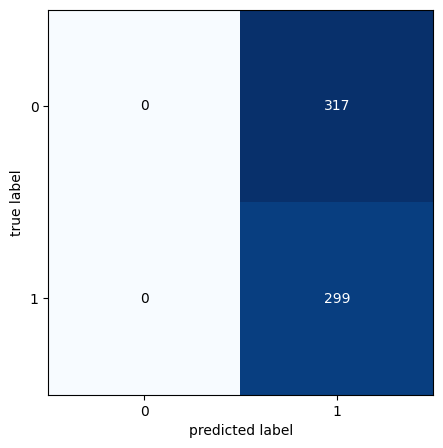

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
y_test = labels
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))
plt.show()

In [ ]:
model_save_path = '/content/drive/My Drive/your_folder/"ori_one_fold_basic_transfer_0_0.h5"'
model.save(model_save_path)

165/165 [==============================] - 3s 21ms/step
(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.4909090909090909
0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        84
           1       0.49      1.00      0.66        81

    accuracy                           0.49       165
   macro avg       0.25      0.50      0.33       165
weighted avg       0.24      0.49      0.32       165



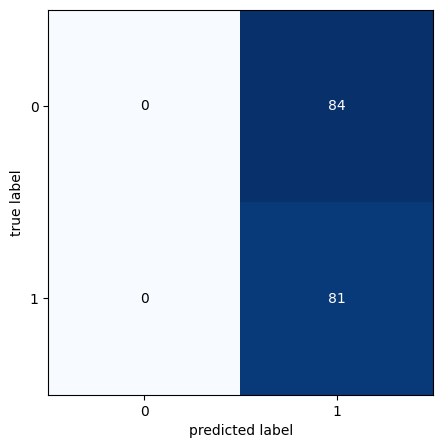

In [ ]:
train_generator_test.reset()
valid_generator_test.reset()
test_generator_test.reset()
combined_prediction = []
combined_prediction.extend(model.predict(test_generator_test))
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator_test)):
    batch_images, batch_labels = test_generator_test.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(combined_prediction))
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
y_test = labels.T
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))

# New Transfer Learning 0 Iterations = 0

In [ ]:
valid_generator.reset()

In [ ]:
img_size = 224
dropout_prob = 0
weights = "DenseNet_224_up_uncrop.h5"
iterations = 0

In [ ]:
class CustomDropout(Layer):
    def __init__(self, dropout_prob,weights = None):
        super(CustomDropout, self).__init__()
        self.dropout_prob = dropout_prob
        self.masks = None

    def call(self, train_inputs, training=False):
        if training:
          if self.masks is not None:
            modified_object = train_inputs * self.masks
            modified_tensor = tf.convert_to_tensor(modified_object)
            return modified_tensor
        return train_inputs

In [ ]:
base_model = DenseNet121(weights=None, include_top=False,
                                 input_shape = (img_size,img_size,3))
x = base_model.output
globa = layers.GlobalAveragePooling2D()
x = globa(x)
dropout = CustomDropout(dropout_prob)
x = dropout(x)
predictions = layers.Dense(1, activation='sigmoid', name='last')
model = Model(inputs=base_model.input, outputs=predictions(x))
model.load_weights(weights)
num_layers_to_freeze = 300  # You can adjust this fraction as needed
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False
x = base_model.output
globa = layers.GlobalAveragePooling2D()
x = globa(x)
dropout_one = CustomDropout(dropout_prob)
x = dropout_one(x)
before_predictions = layers.Dense(128, activation='relu')
x = before_predictions(x)
dropout_two = CustomDropout(dropout_prob)
x = dropout_two(x)
predictions = layers.Dense(1, activation='sigmoid', name='last')
model = Model(inputs=base_model.input, outputs=predictions(x))

In [ ]:
import tensorflow.keras.backend as K
print("Compiling the model...")
def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[0] ** (1 - y_true)) * (weights[1] ** y_true) * K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss
opt = Adam(lr=1e-5)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy","AUC","Precision","Recall"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

Compiling the model...


In [ ]:
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_12 (ZeroPad  (None, 230, 230, 3)          0         ['input_7[0][0]']             
 ding2D)                                                                                          
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_12[0][0]']   
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']   

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 3)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [ ]:
num_batches_to_consider = len(valid_generator)
num_batches_to_consider

8

In [ ]:
def custom_random_binomial(random_values,shape, prob, object_to_modify):
    random_values = np.broadcast_to(random_values, shape)
    mask = (random_values < (1-prob)).astype(np.float32)
    modified_object = object_to_modify * mask
    modified_tensor = tf.convert_to_tensor(modified_object)
    return modified_tensor,mask

In [ ]:
def custom_valid_generator(generator, subset_indices):
    max_index = max(subset_indices, default=-1)
    for i, (x, y) in enumerate(generator):
        if i <= max_index:
            yield (x, y)
        else:
            return

In [ ]:
# train the head of the network
def calculate_metric(test_y, test_preds, metric):
  if metric == "auc":
    try:
      # auc = roc_auc_score(test_y.numpy(), np.argmax(test_preds.numpy(), axis=1))
      auc = roc_auc_score(test_y.numpy(),test_preds.numpy())
      return auc
    except:
      return 0.0
    else:
      raise ValueError("Unsupported metric: " + metric)
print("training the head...")
hist_df_list = []
epochs = 25
dropout = [dropout_one,dropout_two]
for i in range(epochs):
  print(f"Epochs {i+1}")
  best_dropout_score = float("-inf")
  weight_best = None
  if dropout_prob < 0 or dropout_prob > 1:
    raise ValueError('Dropout probability has to be between 0 and 1, but got ' + str(dropout_prob))
  for iteration in range(iterations):
    np.random.seed((i+1) * iterations)
    # dropout_layer = tf.keras.layers.Dropout(dropout_prob)
    vbatch_images_array = []
    vbatch_labels_array = []
    for v_step in range(num_batches_to_consider):
      vbatch_images, vbatch_labels = valid_generator[v_step]
      vbatch_images_array.append(vbatch_images)
      vbatch_labels_array.append(vbatch_labels)
    vbatch_images = np.concatenate(vbatch_images_array)
    vbatch_labels = np.concatenate(vbatch_labels_array)

    output = globa(base_model(vbatch_images))
    shape = output.shape
    random_values_one = np.random.random(shape)[0]
    non_mask_one,mask_numpy_one = custom_random_binomial(random_values_one,shape,dropout_prob,output)
    output = before_predictions(non_mask_one)
    shape = output.shape
    random_values_two = np.random.random(shape)[0]
    non_mask_two,mask_numpy_two = custom_random_binomial(random_values_two,shape,dropout_prob,output)
    dropout_score = calculate_metric(vbatch_labels,predictions(non_mask_two),"auc")
    if dropout_score > best_dropout_score:
      best_dropout_score = dropout_score
      weight_best_one = random_values_one
      weight_best_two = random_values_two
  if weight_best is not None:
    dropout[0].masks = weight_best_one
    dropout[1].masks = weight_best_two
  model.compile(loss='binary_crossentropy', optimizer="RMSprop", metrics=["accuracy","AUC","Precision","Recall"])
  history = model.fit(
          train_generator,
          epochs = 1,
          validation_data=valid_generator,
          callbacks=[cb_checkpointer,learning_rate_reduction,cb_early_stopper],
   )
  epoch_hist_df = pd.DataFrame(history.history)
  hist_df_list.append(epoch_hist_df)

# convert the history.history dict to a pandas DataFrame:
hist_df = pd.concat(hist_df_list, ignore_index=True)

training the head...
Epochs 1
31/31 [==============================] - 57s 1s/step - loss: 0.5469 - accuracy: 0.7239 - auc: 0.8162 - precision: 0.7141 - recall: 0.7194 - val_loss: 0.6366 - val_accuracy: 0.5882 - val_auc: 0.9494 - val_precision: 1.0000 - val_recall: 0.1506 - lr: 0.0010
Epochs 2
31/31 [==============================] - 56s 1s/step - loss: 0.3302 - accuracy: 0.8638 - auc: 0.9353 - precision: 0.8643 - recall: 0.8534 - val_loss: 0.2996 - val_accuracy: 0.8824 - val_auc: 0.9647 - val_precision: 0.9502 - val_recall: 0.7992 - lr: 0.0010
Epochs 3
31/31 [==============================] - 67s 1s/step - loss: 0.2679 - accuracy: 0.9039 - auc: 0.9555 - precision: 0.9101 - recall: 0.8901 - val_loss: 0.2756 - val_accuracy: 0.8925 - val_auc: 0.9663 - val_precision: 0.9604 - val_recall: 0.8117 - lr: 0.0010
Epochs 4
31/31 [==============================] - 56s 1s/step - loss: 0.2404 - accuracy: 0.9090 - auc: 0.9629 - precision: 0.9145 - recall: 0.8963 - val_loss: 0.4034 - val_accuracy: 0.

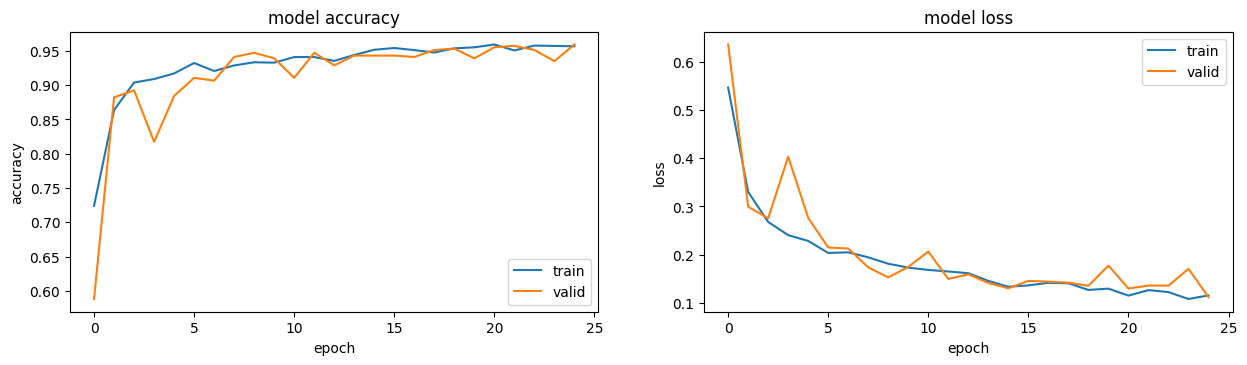

In [ ]:
plt.figure(1, figsize = (15,8))
plt.subplot(221)
plt.plot(hist_df['accuracy'])
plt.plot(hist_df['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.subplot(222)
plt.plot(hist_df['loss'])
plt.plot(hist_df['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

In [ ]:
test_generator.reset()
prediction = model.predict(test_generator)
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator)):
    batch_images, batch_labels = test_generator.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(prediction))

616/616 [==============================] - 36s 56ms/step


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.948051948051948
0.9474378316786766
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       317
           1       0.97      0.93      0.95       299

    accuracy                           0.95       616
   macro avg       0.95      0.95      0.95       616
weighted avg       0.95      0.95      0.95       616



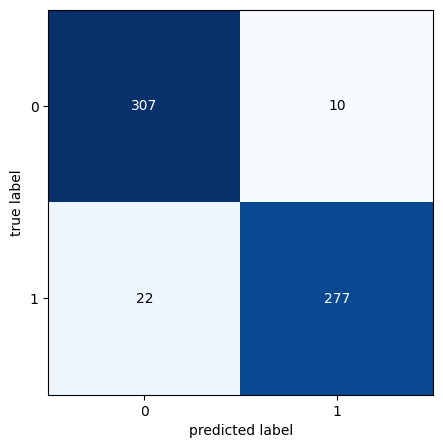

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
predicted_class_indices = np.round(predicted_class_indices)
y_test = labels
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))
plt.show()

In [ ]:
model_save_path = '/content/drive/My Drive/your_folder/"ori_one_fold_new_transfer_09_20.h5"'
model.save(model_save_path)

165/165 [==============================] - 8s 49ms/step
(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.5818181818181818
0.5749559082892416
              precision    recall  f1-score   support

           0       0.55      0.95      0.70        84
           1       0.80      0.20      0.32        81

    accuracy                           0.58       165
   macro avg       0.68      0.57      0.51       165
weighted avg       0.67      0.58      0.51       165



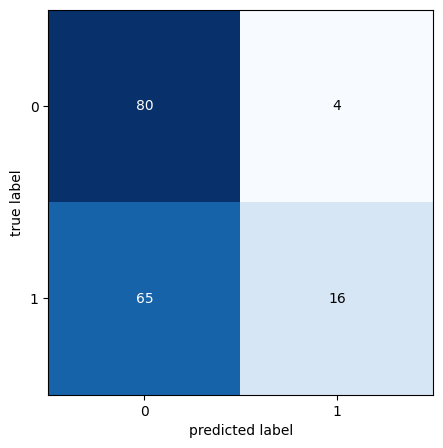

In [ ]:
train_generator_test.reset()
valid_generator_test.reset()
test_generator_test.reset()
combined_prediction = []
combined_prediction.extend(model.predict(test_generator_test))
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator_test)):
    batch_images, batch_labels = test_generator_test.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(combined_prediction))
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
y_test = labels.T
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))

# New Transfer Learning 0.3 Iterations = 10

In [ ]:
valid_generator.reset()

In [ ]:
img_size = 224
dropout_prob = 0.3
weights = "DenseNet_224_up_uncrop.h5"
iterations = 10

In [ ]:
class CustomDropout(Layer):
    def __init__(self, dropout_prob,weights = None):
        super(CustomDropout, self).__init__()
        self.dropout_prob = dropout_prob
        self.masks = None

    def call(self, train_inputs, training=False):
        if training:
          if self.masks is not None:
            modified_object = train_inputs * self.masks
            modified_tensor = tf.convert_to_tensor(modified_object)
            return modified_tensor
        return train_inputs

In [ ]:
base_model = DenseNet121(weights=None, include_top=False,
                                 input_shape = (img_size,img_size,3))
x = base_model.output
globa = layers.GlobalAveragePooling2D()
x = globa(x)
dropout = CustomDropout(dropout_prob)
x = dropout(x)
predictions = layers.Dense(1, activation='sigmoid', name='last')
model = Model(inputs=base_model.input, outputs=predictions(x))
model.load_weights(weights)
num_layers_to_freeze = 300  # You can adjust this fraction as needed
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False
x = base_model.output
globa = layers.GlobalAveragePooling2D()
x = globa(x)
dropout_one = CustomDropout(dropout_prob)
x = dropout_one(x)
before_predictions = layers.Dense(128, activation='relu')
x = before_predictions(x)
dropout_two = CustomDropout(dropout_prob)
x = dropout_two(x)
predictions = layers.Dense(1, activation='sigmoid', name='last')
model = Model(inputs=base_model.input, outputs=predictions(x))

In [ ]:
import tensorflow.keras.backend as K
print("Compiling the model...")
def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[0] ** (1 - y_true)) * (weights[1] ** y_true) * K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss
opt = Adam(lr=1e-5)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy","AUC","Precision","Recall"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

Compiling the model...


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 3)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [ ]:
num_batches_to_consider = len(valid_generator)
num_batches_to_consider

8

In [ ]:
def custom_random_binomial(random_values,shape, prob, object_to_modify):
    random_values = np.broadcast_to(random_values, shape)
    mask = (random_values < (1-prob)).astype(np.float32)
    modified_object = object_to_modify * mask
    modified_tensor = tf.convert_to_tensor(modified_object)
    return modified_tensor,mask

In [ ]:
def custom_valid_generator(generator, subset_indices):
    max_index = max(subset_indices, default=-1)
    for i, (x, y) in enumerate(generator):
        if i <= max_index:
            yield (x, y)
        else:
            return

In [ ]:
# train the head of the network
def calculate_metric(test_y, test_preds, metric):
  if metric == "auc":
    try:
      # auc = roc_auc_score(test_y.numpy(), np.argmax(test_preds.numpy(), axis=1))
      auc = roc_auc_score(test_y.numpy(),test_preds.numpy())
      return auc
    except:
      return 0.0
    else:
      raise ValueError("Unsupported metric: " + metric)
print("training the head...")
hist_df_list = []
epochs = 25
dropout = [dropout_one,dropout_two]
for i in range(epochs):
  print(f"Epochs {i+1}")
  best_dropout_score = float("-inf")
  weight_best = None
  if dropout_prob < 0 or dropout_prob > 1:
    raise ValueError('Dropout probability has to be between 0 and 1, but got ' + str(dropout_prob))
  for iteration in range(iterations):
    np.random.seed((i+1) * iterations)
    # dropout_layer = tf.keras.layers.Dropout(dropout_prob)
    vbatch_images_array = []
    vbatch_labels_array = []
    for v_step in range(num_batches_to_consider):
      vbatch_images, vbatch_labels = valid_generator[v_step]
      vbatch_images_array.append(vbatch_images)
      vbatch_labels_array.append(vbatch_labels)
    vbatch_images = np.concatenate(vbatch_images_array)
    vbatch_labels = np.concatenate(vbatch_labels_array)

    output = globa(base_model(vbatch_images))
    shape = output.shape
    random_values_one = np.random.random(shape)[0]
    non_mask_one,mask_numpy_one = custom_random_binomial(random_values_one,shape,dropout_prob,output)
    output = before_predictions(non_mask_one)
    shape = output.shape
    random_values_two = np.random.random(shape)[0]
    non_mask_two,mask_numpy_two = custom_random_binomial(random_values_two,shape,dropout_prob,output)
    dropout_score = calculate_metric(vbatch_labels,predictions(non_mask_two),"auc")
    if dropout_score > best_dropout_score:
      best_dropout_score = dropout_score
      weight_best_one = random_values_one
      weight_best_two = random_values_two
  if weight_best is not None:
    dropout[0].masks = weight_best_one
    dropout[1].masks = weight_best_two
  model.compile(loss='binary_crossentropy', optimizer="RMSprop", metrics=["accuracy","AUC","Precision","Recall"])
  history = model.fit(
          train_generator,
          epochs = 1,
          validation_data=valid_generator,
          callbacks=[cb_checkpointer,learning_rate_reduction,cb_early_stopper],
   )
  epoch_hist_df = pd.DataFrame(history.history)
  hist_df_list.append(epoch_hist_df)

# convert the history.history dict to a pandas DataFrame:
hist_df = pd.concat(hist_df_list, ignore_index=True)

training the head...
Epochs 1
31/31 [==============================] - 56s 1s/step - loss: 0.5187 - accuracy: 0.7494 - auc: 0.8316 - precision: 0.7544 - recall: 0.7173 - val_loss: 0.4362 - val_accuracy: 0.7992 - val_auc: 0.9478 - val_precision: 0.9545 - val_recall: 0.6151 - lr: 0.0010
Epochs 2
31/31 [==============================] - 49s 1s/step - loss: 0.3128 - accuracy: 0.8876 - auc: 0.9397 - precision: 0.8753 - recall: 0.8963 - val_loss: 0.2672 - val_accuracy: 0.8945 - val_auc: 0.9696 - val_precision: 0.9231 - val_recall: 0.8536 - lr: 0.0010
Epochs 3
31/31 [==============================] - 47s 1s/step - loss: 0.2511 - accuracy: 0.9110 - auc: 0.9606 - precision: 0.9021 - recall: 0.9162 - val_loss: 0.2916 - val_accuracy: 0.8682 - val_auc: 0.9694 - val_precision: 0.9628 - val_recall: 0.7573 - lr: 0.0010
Epochs 4
31/31 [==============================] - 49s 1s/step - loss: 0.2340 - accuracy: 0.9080 - auc: 0.9652 - precision: 0.9057 - recall: 0.9047 - val_loss: 0.2613 - val_accuracy: 0.

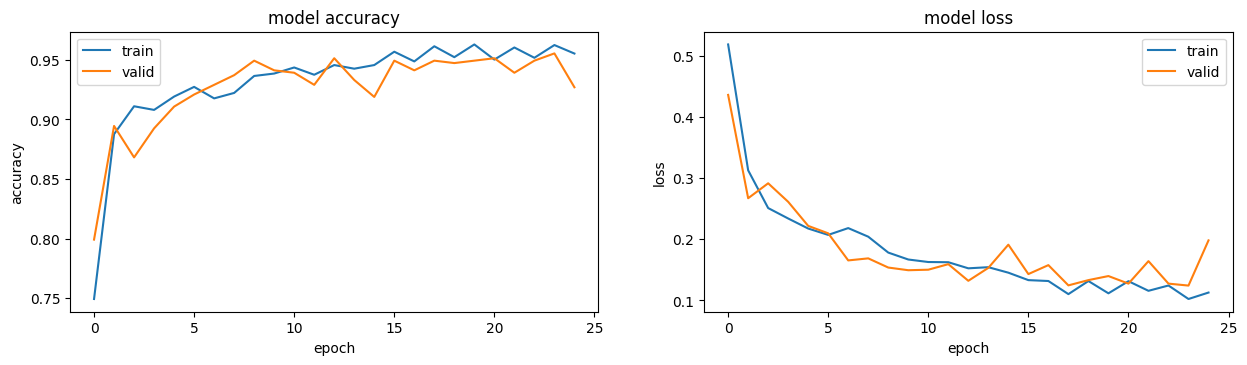

In [ ]:
plt.figure(1, figsize = (15,8))
plt.subplot(221)
plt.plot(hist_df['accuracy'])
plt.plot(hist_df['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.subplot(222)
plt.plot(hist_df['loss'])
plt.plot(hist_df['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

In [ ]:
test_generator.reset()
prediction = model.predict(test_generator)
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator)):
    batch_images, batch_labels = test_generator.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(prediction))

616/616 [==============================] - 20s 27ms/step


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.9415584415584416
0.939799331103679
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       317
           1       1.00      0.88      0.94       299

    accuracy                           0.94       616
   macro avg       0.95      0.94      0.94       616
weighted avg       0.95      0.94      0.94       616



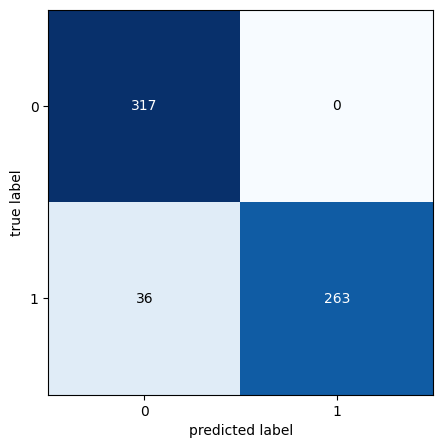

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
predicted_class_indices = np.round(predicted_class_indices)
y_test = labels
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))
plt.show()

In [ ]:
model_save_path = '/content/drive/My Drive/your_folder/"ori_one_fold_new_transfer_09_20.h5"'
model.save(model_save_path)

165/165 [==============================] - 4s 24ms/step
(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.593939393939394
0.5866402116402116
              precision    recall  f1-score   support

           0       0.56      0.99      0.71        84
           1       0.94      0.19      0.31        81

    accuracy                           0.59       165
   macro avg       0.75      0.59      0.51       165
weighted avg       0.74      0.59      0.51       165



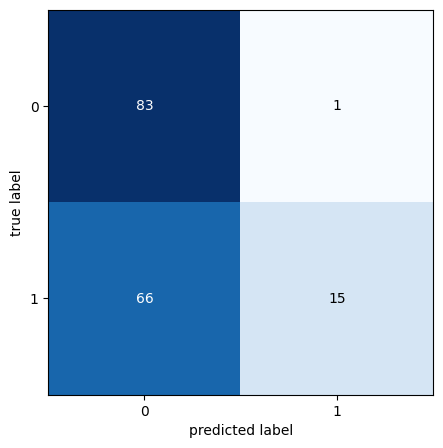

In [ ]:
train_generator_test.reset()
valid_generator_test.reset()
test_generator_test.reset()
combined_prediction = []
combined_prediction.extend(model.predict(test_generator_test))
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator_test)):
    batch_images, batch_labels = test_generator_test.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(combined_prediction))
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
y_test = labels.T
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))

# New Transfer Learning 0.6 Iterations = 10

In [ ]:
valid_generator.reset()

In [ ]:
img_size = 224
dropout_prob = 0.6
weights = "DenseNet_224_up_uncrop.h5"
iterations = 10

In [ ]:
class CustomDropout(Layer):
    def __init__(self, dropout_prob,weights = None):
        super(CustomDropout, self).__init__()
        self.dropout_prob = dropout_prob
        self.masks = None

    def call(self, train_inputs, training=False):
        if training:
          if self.masks is not None:
            modified_object = train_inputs * self.masks
            modified_tensor = tf.convert_to_tensor(modified_object)
            return modified_tensor
        return train_inputs

In [ ]:
base_model = DenseNet121(weights=None, include_top=False,
                                 input_shape = (img_size,img_size,3))
x = base_model.output
globa = layers.GlobalAveragePooling2D()
x = globa(x)
dropout = CustomDropout(dropout_prob)
x = dropout(x)
predictions = layers.Dense(1, activation='sigmoid', name='last')
model = Model(inputs=base_model.input, outputs=predictions(x))
model.load_weights(weights)
num_layers_to_freeze = 300  # You can adjust this fraction as needed
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False
x = base_model.output
globa = layers.GlobalAveragePooling2D()
x = globa(x)
dropout_one = CustomDropout(dropout_prob)
x = dropout_one(x)
before_predictions = layers.Dense(128, activation='relu')
x = before_predictions(x)
dropout_two = CustomDropout(dropout_prob)
x = dropout_two(x)
predictions = layers.Dense(1, activation='sigmoid', name='last')
model = Model(inputs=base_model.input, outputs=predictions(x))

In [ ]:
import tensorflow.keras.backend as K
print("Compiling the model...")
def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[0] ** (1 - y_true)) * (weights[1] ** y_true) * K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss
opt = Adam(lr=1e-5)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy","AUC","Precision","Recall"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

Compiling the model...


In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 230, 230, 3)          0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 3)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [ ]:
num_batches_to_consider = len(valid_generator)
num_batches_to_consider

8

In [ ]:
def custom_random_binomial(random_values,shape, prob, object_to_modify):
    random_values = np.broadcast_to(random_values, shape)
    mask = (random_values < (1-prob)).astype(np.float32)
    modified_object = object_to_modify * mask
    modified_tensor = tf.convert_to_tensor(modified_object)
    return modified_tensor,mask

In [ ]:
def custom_valid_generator(generator, subset_indices):
    max_index = max(subset_indices, default=-1)
    for i, (x, y) in enumerate(generator):
        if i <= max_index:
            yield (x, y)
        else:
            return

In [ ]:
# train the head of the network
def calculate_metric(test_y, test_preds, metric):
  if metric == "auc":
    try:
      # auc = roc_auc_score(test_y.numpy(), np.argmax(test_preds.numpy(), axis=1))
      auc = roc_auc_score(test_y.numpy(),test_preds.numpy())
      return auc
    except:
      return 0.0
    else:
      raise ValueError("Unsupported metric: " + metric)
print("training the head...")
hist_df_list = []
epochs = 25
dropout = [dropout_one,dropout_two]
for i in range(epochs):
  print(f"Epochs {i+1}")
  best_dropout_score = float("-inf")
  weight_best = None
  if dropout_prob < 0 or dropout_prob > 1:
    raise ValueError('Dropout probability has to be between 0 and 1, but got ' + str(dropout_prob))
  for iteration in range(iterations):
    np.random.seed((i+1) * iterations)
    # dropout_layer = tf.keras.layers.Dropout(dropout_prob)
    vbatch_images_array = []
    vbatch_labels_array = []
    for v_step in range(num_batches_to_consider):
      vbatch_images, vbatch_labels = valid_generator[v_step]
      vbatch_images_array.append(vbatch_images)
      vbatch_labels_array.append(vbatch_labels)
    vbatch_images = np.concatenate(vbatch_images_array)
    vbatch_labels = np.concatenate(vbatch_labels_array)

    output = globa(base_model(vbatch_images))
    shape = output.shape
    random_values_one = np.random.random(shape)[0]
    non_mask_one,mask_numpy_one = custom_random_binomial(random_values_one,shape,dropout_prob,output)
    output = before_predictions(non_mask_one)
    shape = output.shape
    random_values_two = np.random.random(shape)[0]
    non_mask_two,mask_numpy_two = custom_random_binomial(random_values_two,shape,dropout_prob,output)
    dropout_score = calculate_metric(vbatch_labels,predictions(non_mask_two),"auc")
    if dropout_score > best_dropout_score:
      best_dropout_score = dropout_score
      weight_best_one = random_values_one
      weight_best_two = random_values_two
  if weight_best is not None:
    dropout[0].masks = weight_best_one
    dropout[1].masks = weight_best_two
  model.compile(loss='binary_crossentropy', optimizer="RMSprop", metrics=["accuracy","AUC","Precision","Recall"])
  history = model.fit(
          train_generator,
          epochs = 1,
          validation_data=valid_generator,
          callbacks=[cb_checkpointer,learning_rate_reduction,cb_early_stopper],
   )
  epoch_hist_df = pd.DataFrame(history.history)
  hist_df_list.append(epoch_hist_df)

# convert the history.history dict to a pandas DataFrame:
hist_df = pd.concat(hist_df_list, ignore_index=True)

training the head...
Epochs 1
31/31 [==============================] - 50s 1s/step - loss: 0.5767 - accuracy: 0.7448 - auc: 0.7849 - precision: 0.7548 - recall: 0.7026 - val_loss: 0.4822 - val_accuracy: 0.7708 - val_auc: 0.9487 - val_precision: 0.9773 - val_recall: 0.5397 - lr: 0.0010
Epochs 2
31/31 [==============================] - 50s 1s/step - loss: 0.3294 - accuracy: 0.8693 - auc: 0.9378 - precision: 0.8658 - recall: 0.8649 - val_loss: 0.4766 - val_accuracy: 0.7647 - val_auc: 0.9533 - val_precision: 0.9843 - val_recall: 0.5230 - lr: 0.0010
Epochs 3
31/31 [==============================] - 48s 1s/step - loss: 0.2638 - accuracy: 0.8963 - auc: 0.9569 - precision: 0.8948 - recall: 0.8911 - val_loss: 0.4085 - val_accuracy: 0.8195 - val_auc: 0.9662 - val_precision: 0.9688 - val_recall: 0.6485 - lr: 0.0010
Epochs 4
31/31 [==============================] - 51s 1s/step - loss: 0.2514 - accuracy: 0.8993 - auc: 0.9607 - precision: 0.8972 - recall: 0.8953 - val_loss: 0.2703 - val_accuracy: 0.

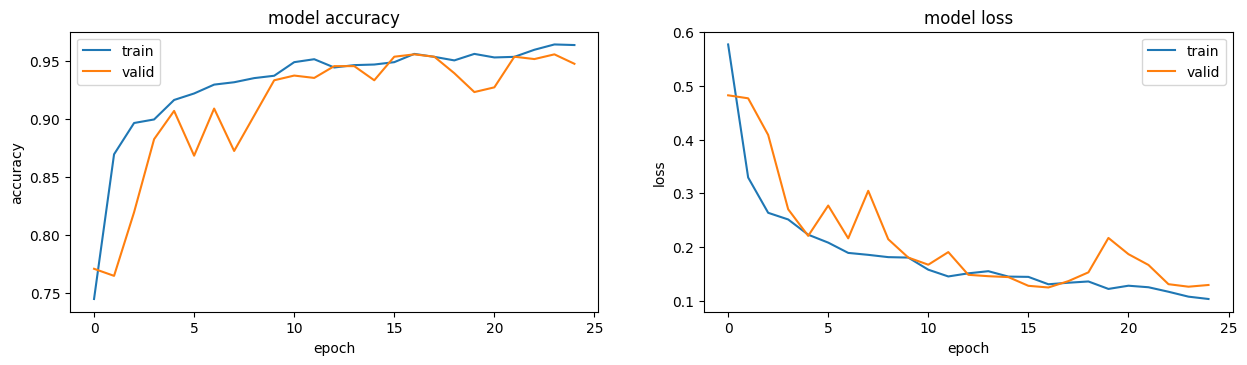

In [ ]:
plt.figure(1, figsize = (15,8))
plt.subplot(221)
plt.plot(hist_df['accuracy'])
plt.plot(hist_df['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.subplot(222)
plt.plot(hist_df['loss'])
plt.plot(hist_df['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

In [ ]:
test_generator.reset()
prediction = model.predict(test_generator)
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator)):
    batch_images, batch_labels = test_generator.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(prediction))

616/616 [==============================] - 17s 24ms/step


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.9545454545454546
0.9539368874165198
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       317
           1       0.97      0.93      0.95       299

    accuracy                           0.95       616
   macro avg       0.96      0.95      0.95       616
weighted avg       0.96      0.95      0.95       616



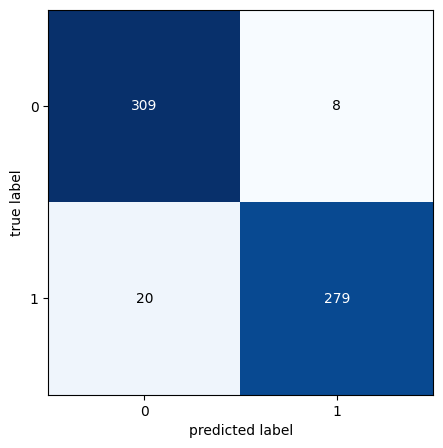

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
predicted_class_indices = np.round(predicted_class_indices)
y_test = labels
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))
plt.show()

In [ ]:
model_save_path = '/content/drive/My Drive/your_folder/"ori_one_fold_new_transfer_09_20.h5"'
model.save(model_save_path)

165/165 [==============================] - 4s 24ms/step
(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.593939393939394
0.5873015873015872
              precision    recall  f1-score   support

           0       0.56      0.95      0.70        84
           1       0.82      0.22      0.35        81

    accuracy                           0.59       165
   macro avg       0.69      0.59      0.53       165
weighted avg       0.69      0.59      0.53       165



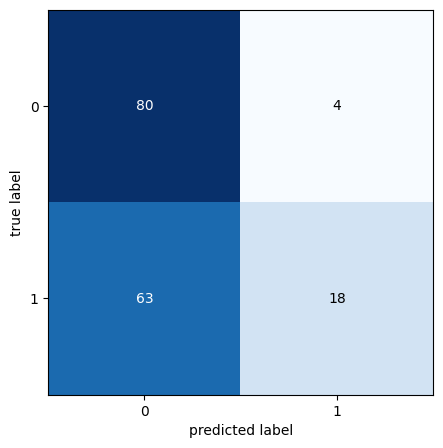

In [ ]:
train_generator_test.reset()
valid_generator_test.reset()
test_generator_test.reset()
combined_prediction = []
combined_prediction.extend(model.predict(test_generator_test))
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator_test)):
    batch_images, batch_labels = test_generator_test.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(combined_prediction))
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
y_test = labels.T
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))

# New Transfer Learning 0.9 Iterations = 10

In [ ]:
valid_generator.reset()

In [ ]:
img_size = 224
dropout_prob = 0.9
weights = "DenseNet_224_up_uncrop.h5"
iterations = 10

In [ ]:
class CustomDropout(Layer):
    def __init__(self, dropout_prob,weights = None):
        super(CustomDropout, self).__init__()
        self.dropout_prob = dropout_prob
        self.masks = None

    def call(self, train_inputs, training=False):
        if training:
          if self.masks is not None:
            modified_object = train_inputs * self.masks
            modified_tensor = tf.convert_to_tensor(modified_object)
            return modified_tensor
        return train_inputs

In [ ]:
base_model = DenseNet121(weights=None, include_top=False,
                                 input_shape = (img_size,img_size,3))
x = base_model.output
globa = layers.GlobalAveragePooling2D()
x = globa(x)
dropout = CustomDropout(dropout_prob)
x = dropout(x)
predictions = layers.Dense(1, activation='sigmoid', name='last')
model = Model(inputs=base_model.input, outputs=predictions(x))
model.load_weights(weights)
num_layers_to_freeze = 300  # You can adjust this fraction as needed
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False
x = base_model.output
globa = layers.GlobalAveragePooling2D()
x = globa(x)
dropout_one = CustomDropout(dropout_prob)
x = dropout_one(x)
before_predictions = layers.Dense(128, activation='relu')
x = before_predictions(x)
dropout_two = CustomDropout(dropout_prob)
x = dropout_two(x)
predictions = layers.Dense(1, activation='sigmoid', name='last')
model = Model(inputs=base_model.input, outputs=predictions(x))

In [ ]:
import tensorflow.keras.backend as K
print("Compiling the model...")
def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[0] ** (1 - y_true)) * (weights[1] ** y_true) * K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss
opt = Adam(lr=1e-5)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy","AUC","Precision","Recall"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

Compiling the model...


In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_4 (ZeroPadd  (None, 230, 230, 3)          0         ['input_3[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_4[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 3)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [ ]:
num_batches_to_consider = len(valid_generator)
num_batches_to_consider

8

In [ ]:
def custom_random_binomial(random_values,shape, prob, object_to_modify):
    random_values = np.broadcast_to(random_values, shape)
    mask = (random_values < (1-prob)).astype(np.float32)
    modified_object = object_to_modify * mask
    modified_tensor = tf.convert_to_tensor(modified_object)
    return modified_tensor,mask

In [ ]:
def custom_valid_generator(generator, subset_indices):
    max_index = max(subset_indices, default=-1)
    for i, (x, y) in enumerate(generator):
        if i <= max_index:
            yield (x, y)
        else:
            return

In [ ]:
# train the head of the network
def calculate_metric(test_y, test_preds, metric):
  if metric == "auc":
    try:
      # auc = roc_auc_score(test_y.numpy(), np.argmax(test_preds.numpy(), axis=1))
      auc = roc_auc_score(test_y.numpy(),test_preds.numpy())
      return auc
    except:
      return 0.0
    else:
      raise ValueError("Unsupported metric: " + metric)
print("training the head...")
hist_df_list = []
epochs = 25
dropout = [dropout_one,dropout_two]
for i in range(epochs):
  print(f"Epochs {i+1}")
  best_dropout_score = float("-inf")
  weight_best = None
  if dropout_prob < 0 or dropout_prob > 1:
    raise ValueError('Dropout probability has to be between 0 and 1, but got ' + str(dropout_prob))
  for iteration in range(iterations):
    np.random.seed((i+1) * iterations)
    # dropout_layer = tf.keras.layers.Dropout(dropout_prob)
    vbatch_images_array = []
    vbatch_labels_array = []
    for v_step in range(num_batches_to_consider):
      vbatch_images, vbatch_labels = valid_generator[v_step]
      vbatch_images_array.append(vbatch_images)
      vbatch_labels_array.append(vbatch_labels)
    vbatch_images = np.concatenate(vbatch_images_array)
    vbatch_labels = np.concatenate(vbatch_labels_array)

    output = globa(base_model(vbatch_images))
    shape = output.shape
    random_values_one = np.random.random(shape)[0]
    non_mask_one,mask_numpy_one = custom_random_binomial(random_values_one,shape,dropout_prob,output)
    output = before_predictions(non_mask_one)
    shape = output.shape
    random_values_two = np.random.random(shape)[0]
    non_mask_two,mask_numpy_two = custom_random_binomial(random_values_two,shape,dropout_prob,output)
    dropout_score = calculate_metric(vbatch_labels,predictions(non_mask_two),"auc")
    if dropout_score > best_dropout_score:
      best_dropout_score = dropout_score
      weight_best_one = random_values_one
      weight_best_two = random_values_two
  if weight_best is not None:
    dropout[0].masks = weight_best_one
    dropout[1].masks = weight_best_two
  model.compile(loss='binary_crossentropy', optimizer="RMSprop", metrics=["accuracy","AUC","Precision","Recall"])
  history = model.fit(
          train_generator,
          epochs = 1,
          validation_data=valid_generator,
          callbacks=[cb_checkpointer,learning_rate_reduction,cb_early_stopper],
   )
  epoch_hist_df = pd.DataFrame(history.history)
  hist_df_list.append(epoch_hist_df)

# convert the history.history dict to a pandas DataFrame:
hist_df = pd.concat(hist_df_list, ignore_index=True)

training the head...
Epochs 1
31/31 [==============================] - 47s 1s/step - loss: 0.5695 - accuracy: 0.6950 - auc: 0.7830 - precision: 0.6907 - recall: 0.6733 - val_loss: 0.4561 - val_accuracy: 0.8621 - val_auc: 0.9419 - val_precision: 0.8301 - val_recall: 0.8996 - lr: 0.0010
Epochs 2
31/31 [==============================] - 48s 1s/step - loss: 0.3450 - accuracy: 0.8643 - auc: 0.9274 - precision: 0.8747 - recall: 0.8408 - val_loss: 0.2865 - val_accuracy: 0.8966 - val_auc: 0.9602 - val_precision: 0.8917 - val_recall: 0.8954 - lr: 0.0010
Epochs 3
31/31 [==============================] - 49s 1s/step - loss: 0.2597 - accuracy: 0.9014 - auc: 0.9568 - precision: 0.9122 - recall: 0.8817 - val_loss: 0.2773 - val_accuracy: 0.8925 - val_auc: 0.9671 - val_precision: 0.9650 - val_recall: 0.8075 - lr: 0.0010
Epochs 4
31/31 [==============================] - 49s 1s/step - loss: 0.2525 - accuracy: 0.9049 - auc: 0.9603 - precision: 0.9008 - recall: 0.9037 - val_loss: 0.3725 - val_accuracy: 0.

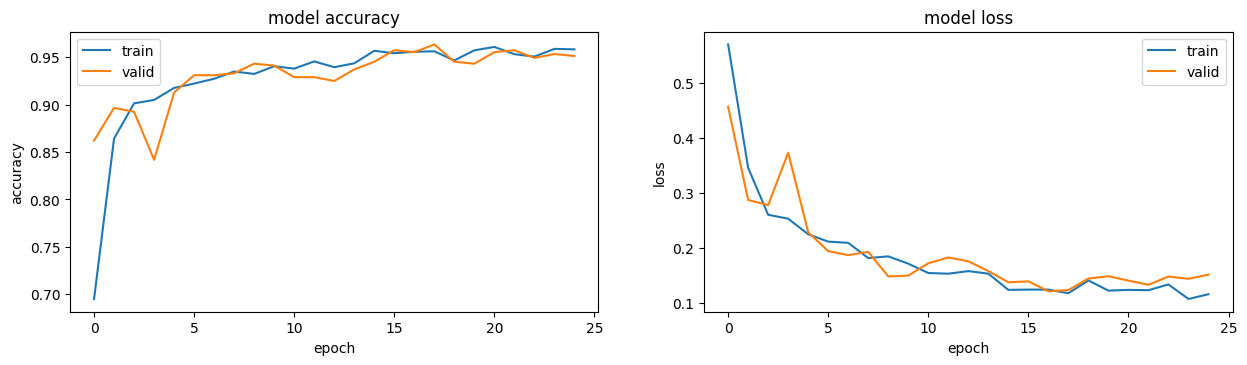

In [ ]:
plt.figure(1, figsize = (15,8))
plt.subplot(221)
plt.plot(hist_df['accuracy'])
plt.plot(hist_df['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.subplot(222)
plt.plot(hist_df['loss'])
plt.plot(hist_df['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

In [ ]:
test_generator.reset()
prediction = model.predict(test_generator)
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator)):
    batch_images, batch_labels = test_generator.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(prediction))

616/616 [==============================] - 16s 23ms/step


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.9496753246753247
0.9490151187449226
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       317
           1       0.97      0.93      0.95       299

    accuracy                           0.95       616
   macro avg       0.95      0.95      0.95       616
weighted avg       0.95      0.95      0.95       616



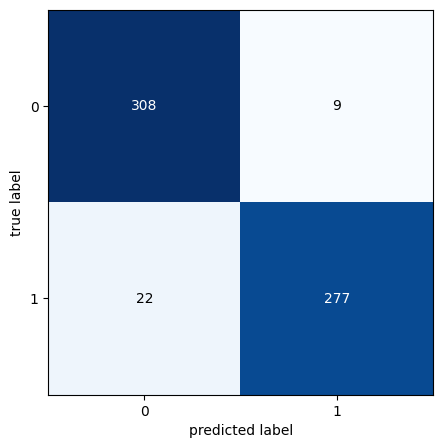

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
predicted_class_indices = np.round(predicted_class_indices)
y_test = labels
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))
plt.show()

In [ ]:
model_save_path = '/content/drive/My Drive/your_folder/"ori_one_fold_new_transfer_09_20.h5"'
model.save(model_save_path)

165/165 [==============================] - 4s 23ms/step
(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.6
0.5930335097001764
              precision    recall  f1-score   support

           0       0.56      0.98      0.71        84
           1       0.89      0.21      0.34        81

    accuracy                           0.60       165
   macro avg       0.73      0.59      0.53       165
weighted avg       0.73      0.60      0.53       165



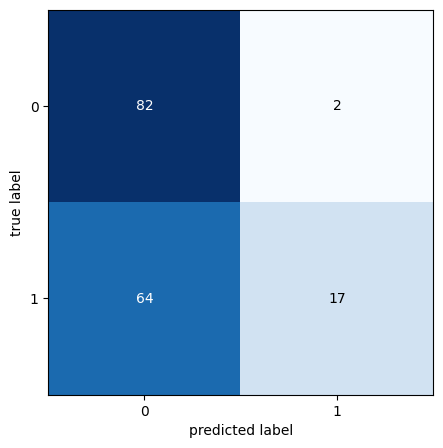

In [ ]:
train_generator_test.reset()
valid_generator_test.reset()
test_generator_test.reset()
combined_prediction = []
combined_prediction.extend(model.predict(test_generator_test))
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator_test)):
    batch_images, batch_labels = test_generator_test.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(combined_prediction))
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
y_test = labels.T
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))

# New Transfer Learning 0.3 Iterations = 20

In [ ]:
valid_generator.reset()

In [ ]:
img_size = 224
dropout_prob = 0.3
weights = "DenseNet_224_up_uncrop.h5"
iterations = 20

In [ ]:
class CustomDropout(Layer):
    def __init__(self, dropout_prob,weights = None):
        super(CustomDropout, self).__init__()
        self.dropout_prob = dropout_prob
        self.masks = None

    def call(self, train_inputs, training=False):
        if training:
          if self.masks is not None:
            modified_object = train_inputs * self.masks
            modified_tensor = tf.convert_to_tensor(modified_object)
            return modified_tensor
        return train_inputs

In [ ]:
base_model = DenseNet121(weights=None, include_top=False,
                                 input_shape = (img_size,img_size,3))
x = base_model.output
globa = layers.GlobalAveragePooling2D()
x = globa(x)
dropout = CustomDropout(dropout_prob)
x = dropout(x)
predictions = layers.Dense(1, activation='sigmoid', name='last')
model = Model(inputs=base_model.input, outputs=predictions(x))
model.load_weights(weights)
num_layers_to_freeze = 300  # You can adjust this fraction as needed
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False
x = base_model.output
globa = layers.GlobalAveragePooling2D()
x = globa(x)
dropout_one = CustomDropout(dropout_prob)
x = dropout_one(x)
before_predictions = layers.Dense(128, activation='relu')
x = before_predictions(x)
dropout_two = CustomDropout(dropout_prob)
x = dropout_two(x)
predictions = layers.Dense(1, activation='sigmoid', name='last')
model = Model(inputs=base_model.input, outputs=predictions(x))

In [ ]:
import tensorflow.keras.backend as K
print("Compiling the model...")
def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[0] ** (1 - y_true)) * (weights[1] ** y_true) * K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss
opt = Adam(lr=1e-5)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy","AUC","Precision","Recall"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

Compiling the model...


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 3)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [ ]:
num_batches_to_consider = len(valid_generator)
num_batches_to_consider

8

In [ ]:
def custom_random_binomial(random_values,shape, prob, object_to_modify):
    random_values = np.broadcast_to(random_values, shape)
    mask = (random_values < (1-prob)).astype(np.float32)
    modified_object = object_to_modify * mask
    modified_tensor = tf.convert_to_tensor(modified_object)
    return modified_tensor,mask

In [ ]:
def custom_valid_generator(generator, subset_indices):
    max_index = max(subset_indices, default=-1)
    for i, (x, y) in enumerate(generator):
        if i <= max_index:
            yield (x, y)
        else:
            return

In [ ]:
# train the head of the network
def calculate_metric(test_y, test_preds, metric):
  if metric == "auc":
    try:
      # auc = roc_auc_score(test_y.numpy(), np.argmax(test_preds.numpy(), axis=1))
      auc = roc_auc_score(test_y.numpy(),test_preds.numpy())
      return auc
    except:
      return 0.0
    else:
      raise ValueError("Unsupported metric: " + metric)
print("training the head...")
hist_df_list = []
epochs = 25
dropout = [dropout_one,dropout_two]
for i in range(epochs):
  print(f"Epochs {i+1}")
  best_dropout_score = float("-inf")
  weight_best = None
  if dropout_prob < 0 or dropout_prob > 1:
    raise ValueError('Dropout probability has to be between 0 and 1, but got ' + str(dropout_prob))
  for iteration in range(iterations):
    np.random.seed((i+1) * iterations)
    # dropout_layer = tf.keras.layers.Dropout(dropout_prob)
    vbatch_images_array = []
    vbatch_labels_array = []
    for v_step in range(num_batches_to_consider):
      vbatch_images, vbatch_labels = valid_generator[v_step]
      vbatch_images_array.append(vbatch_images)
      vbatch_labels_array.append(vbatch_labels)
    vbatch_images = np.concatenate(vbatch_images_array)
    vbatch_labels = np.concatenate(vbatch_labels_array)

    output = globa(base_model(vbatch_images))
    shape = output.shape
    random_values_one = np.random.random(shape)[0]
    non_mask_one,mask_numpy_one = custom_random_binomial(random_values_one,shape,dropout_prob,output)
    output = before_predictions(non_mask_one)
    shape = output.shape
    random_values_two = np.random.random(shape)[0]
    non_mask_two,mask_numpy_two = custom_random_binomial(random_values_two,shape,dropout_prob,output)
    dropout_score = calculate_metric(vbatch_labels,predictions(non_mask_two),"auc")
    if dropout_score > best_dropout_score:
      best_dropout_score = dropout_score
      weight_best_one = random_values_one
      weight_best_two = random_values_two
  if weight_best is not None:
    dropout[0].masks = weight_best_one
    dropout[1].masks = weight_best_two
  model.compile(loss='binary_crossentropy', optimizer="RMSprop", metrics=["accuracy","AUC","Precision","Recall"])
  history = model.fit(
          train_generator,
          epochs = 1,
          validation_data=valid_generator,
          callbacks=[cb_checkpointer,learning_rate_reduction,cb_early_stopper],
   )
  epoch_hist_df = pd.DataFrame(history.history)
  hist_df_list.append(epoch_hist_df)

# convert the history.history dict to a pandas DataFrame:
hist_df = pd.concat(hist_df_list, ignore_index=True)

training the head...
Epochs 1
31/31 [==============================] - 65s 1s/step - loss: 0.5579 - accuracy: 0.7306 - auc: 0.8083 - precision: 0.7282 - recall: 0.7099 - val_loss: 0.5159 - val_accuracy: 0.6856 - val_auc: 0.9457 - val_precision: 0.9884 - val_recall: 0.3556 - lr: 0.0010
Epochs 2
31/31 [==============================] - 56s 1s/step - loss: 0.3322 - accuracy: 0.8688 - auc: 0.9329 - precision: 0.8680 - recall: 0.8607 - val_loss: 0.4775 - val_accuracy: 0.7525 - val_auc: 0.9606 - val_precision: 0.9835 - val_recall: 0.4979 - lr: 0.0010
Epochs 3
31/31 [==============================] - 59s 1s/step - loss: 0.2745 - accuracy: 0.8937 - auc: 0.9521 - precision: 0.9072 - recall: 0.8702 - val_loss: 0.3845 - val_accuracy: 0.8296 - val_auc: 0.9678 - val_precision: 0.9814 - val_recall: 0.6611 - lr: 0.0010
Epochs 4
31/31 [==============================] - 57s 1s/step - loss: 0.2476 - accuracy: 0.9115 - auc: 0.9603 - precision: 0.9089 - recall: 0.9089 - val_loss: 0.5648 - val_accuracy: 0.

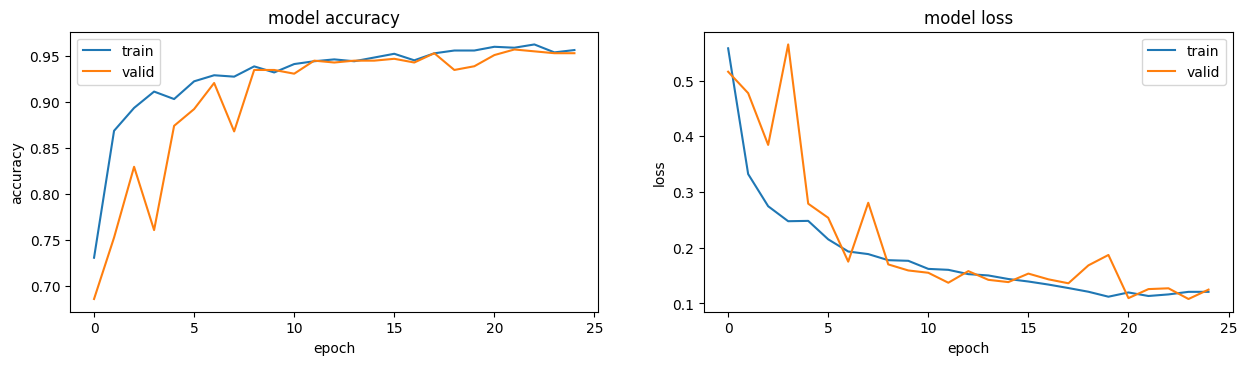

In [ ]:
plt.figure(1, figsize = (15,8))
plt.subplot(221)
plt.plot(hist_df['accuracy'])
plt.plot(hist_df['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.subplot(222)
plt.plot(hist_df['loss'])
plt.plot(hist_df['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

In [ ]:
test_generator.reset()
prediction = model.predict(test_generator)
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator)):
    batch_images, batch_labels = test_generator.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(prediction))

616/616 [==============================] - 35s 52ms/step


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.9577922077922078
0.957091461549012
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       317
           1       0.98      0.93      0.96       299

    accuracy                           0.96       616
   macro avg       0.96      0.96      0.96       616
weighted avg       0.96      0.96      0.96       616



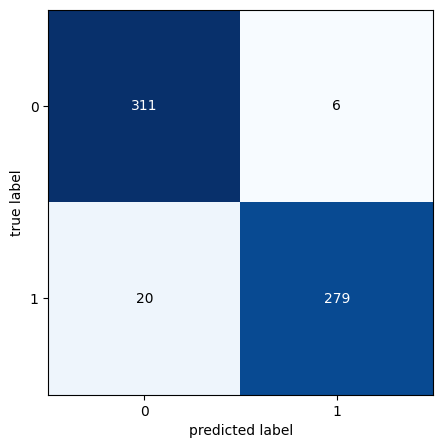

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
predicted_class_indices = np.round(predicted_class_indices)
y_test = labels
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))
plt.show()

In [ ]:
model_save_path = '/content/drive/My Drive/your_folder/"ori_one_fold_new_transfer_09_20.h5"'
model.save(model_save_path)

165/165 [==============================] - 7s 40ms/step
(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.6
0.593694885361552
              precision    recall  f1-score   support

           0       0.56      0.94      0.71        84
           1       0.80      0.25      0.38        81

    accuracy                           0.60       165
   macro avg       0.68      0.59      0.54       165
weighted avg       0.68      0.60      0.54       165



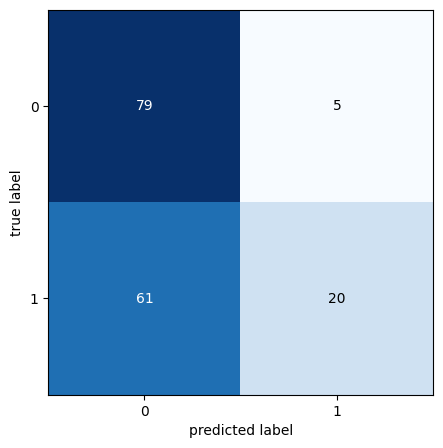

In [ ]:
train_generator_test.reset()
valid_generator_test.reset()
test_generator_test.reset()
combined_prediction = []
combined_prediction.extend(model.predict(test_generator_test))
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator_test)):
    batch_images, batch_labels = test_generator_test.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(combined_prediction))
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
y_test = labels.T
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))

# New Transfer Learning 0.6 Iterations = 20

In [ ]:
valid_generator.reset()

In [ ]:
img_size = 224
dropout_prob = 0.6
weights = "DenseNet_224_up_uncrop.h5"
iterations = 20

In [ ]:
class CustomDropout(Layer):
    def __init__(self, dropout_prob,weights = None):
        super(CustomDropout, self).__init__()
        self.dropout_prob = dropout_prob
        self.masks = None

    def call(self, train_inputs, training=False):
        if training:
          if self.masks is not None:
            modified_object = train_inputs * self.masks
            modified_tensor = tf.convert_to_tensor(modified_object)
            return modified_tensor
        return train_inputs

In [ ]:
base_model = DenseNet121(weights=None, include_top=False,
                                 input_shape = (img_size,img_size,3))
x = base_model.output
globa = layers.GlobalAveragePooling2D()
x = globa(x)
dropout = CustomDropout(dropout_prob)
x = dropout(x)
predictions = layers.Dense(1, activation='sigmoid', name='last')
model = Model(inputs=base_model.input, outputs=predictions(x))
model.load_weights(weights)
num_layers_to_freeze = 300  # You can adjust this fraction as needed
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False
x = base_model.output
globa = layers.GlobalAveragePooling2D()
x = globa(x)
dropout_one = CustomDropout(dropout_prob)
x = dropout_one(x)
before_predictions = layers.Dense(128, activation='relu')
x = before_predictions(x)
dropout_two = CustomDropout(dropout_prob)
x = dropout_two(x)
predictions = layers.Dense(1, activation='sigmoid', name='last')
model = Model(inputs=base_model.input, outputs=predictions(x))

In [ ]:
import tensorflow.keras.backend as K
print("Compiling the model...")
def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[0] ** (1 - y_true)) * (weights[1] ** y_true) * K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss
opt = Adam(lr=1e-5)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy","AUC","Precision","Recall"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

Compiling the model...


In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 230, 230, 3)          0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 3)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [ ]:
num_batches_to_consider = len(valid_generator)
num_batches_to_consider

8

In [ ]:
def custom_random_binomial(random_values,shape, prob, object_to_modify):
    random_values = np.broadcast_to(random_values, shape)
    mask = (random_values < (1-prob)).astype(np.float32)
    modified_object = object_to_modify * mask
    modified_tensor = tf.convert_to_tensor(modified_object)
    return modified_tensor,mask

In [ ]:
def custom_valid_generator(generator, subset_indices):
    max_index = max(subset_indices, default=-1)
    for i, (x, y) in enumerate(generator):
        if i <= max_index:
            yield (x, y)
        else:
            return

In [ ]:
# train the head of the network
def calculate_metric(test_y, test_preds, metric):
  if metric == "auc":
    try:
      # auc = roc_auc_score(test_y.numpy(), np.argmax(test_preds.numpy(), axis=1))
      auc = roc_auc_score(test_y.numpy(),test_preds.numpy())
      return auc
    except:
      return 0.0
    else:
      raise ValueError("Unsupported metric: " + metric)
print("training the head...")
hist_df_list = []
epochs = 25
dropout = [dropout_one,dropout_two]
for i in range(epochs):
  print(f"Epochs {i+1}")
  best_dropout_score = float("-inf")
  weight_best = None
  if dropout_prob < 0 or dropout_prob > 1:
    raise ValueError('Dropout probability has to be between 0 and 1, but got ' + str(dropout_prob))
  for iteration in range(iterations):
    np.random.seed((i+1) * iterations)
    # dropout_layer = tf.keras.layers.Dropout(dropout_prob)
    vbatch_images_array = []
    vbatch_labels_array = []
    for v_step in range(num_batches_to_consider):
      vbatch_images, vbatch_labels = valid_generator[v_step]
      vbatch_images_array.append(vbatch_images)
      vbatch_labels_array.append(vbatch_labels)
    vbatch_images = np.concatenate(vbatch_images_array)
    vbatch_labels = np.concatenate(vbatch_labels_array)

    output = globa(base_model(vbatch_images))
    shape = output.shape
    random_values_one = np.random.random(shape)[0]
    non_mask_one,mask_numpy_one = custom_random_binomial(random_values_one,shape,dropout_prob,output)
    output = before_predictions(non_mask_one)
    shape = output.shape
    random_values_two = np.random.random(shape)[0]
    non_mask_two,mask_numpy_two = custom_random_binomial(random_values_two,shape,dropout_prob,output)
    dropout_score = calculate_metric(vbatch_labels,predictions(non_mask_two),"auc")
    if dropout_score > best_dropout_score:
      best_dropout_score = dropout_score
      weight_best_one = random_values_one
      weight_best_two = random_values_two
  if weight_best is not None:
    dropout[0].masks = weight_best_one
    dropout[1].masks = weight_best_two
  model.compile(loss='binary_crossentropy', optimizer="RMSprop", metrics=["accuracy","AUC","Precision","Recall"])
  history = model.fit(
          train_generator,
          epochs = 1,
          validation_data=valid_generator,
          callbacks=[cb_checkpointer,learning_rate_reduction,cb_early_stopper],
   )
  epoch_hist_df = pd.DataFrame(history.history)
  hist_df_list.append(epoch_hist_df)

# convert the history.history dict to a pandas DataFrame:
hist_df = pd.concat(hist_df_list, ignore_index=True)

training the head...
Epochs 1
31/31 [==============================] - 55s 1s/step - loss: 0.5412 - accuracy: 0.7153 - auc: 0.8143 - precision: 0.7051 - recall: 0.7110 - val_loss: 0.4304 - val_accuracy: 0.8256 - val_auc: 0.9531 - val_precision: 0.9422 - val_recall: 0.6820 - lr: 0.0010
Epochs 2
31/31 [==============================] - 53s 1s/step - loss: 0.3120 - accuracy: 0.8770 - auc: 0.9434 - precision: 0.8757 - recall: 0.8702 - val_loss: 0.2785 - val_accuracy: 0.8986 - val_auc: 0.9675 - val_precision: 0.9437 - val_recall: 0.8410 - lr: 0.0010
Epochs 3
31/31 [==============================] - 62s 1s/step - loss: 0.2569 - accuracy: 0.9034 - auc: 0.9592 - precision: 0.8980 - recall: 0.9037 - val_loss: 0.5147 - val_accuracy: 0.7627 - val_auc: 0.9675 - val_precision: 0.9766 - val_recall: 0.5230 - lr: 0.0010
Epochs 4
31/31 [==============================] - 55s 1s/step - loss: 0.2480 - accuracy: 0.8983 - auc: 0.9623 - precision: 0.9003 - recall: 0.8890 - val_loss: 0.2629 - val_accuracy: 0.

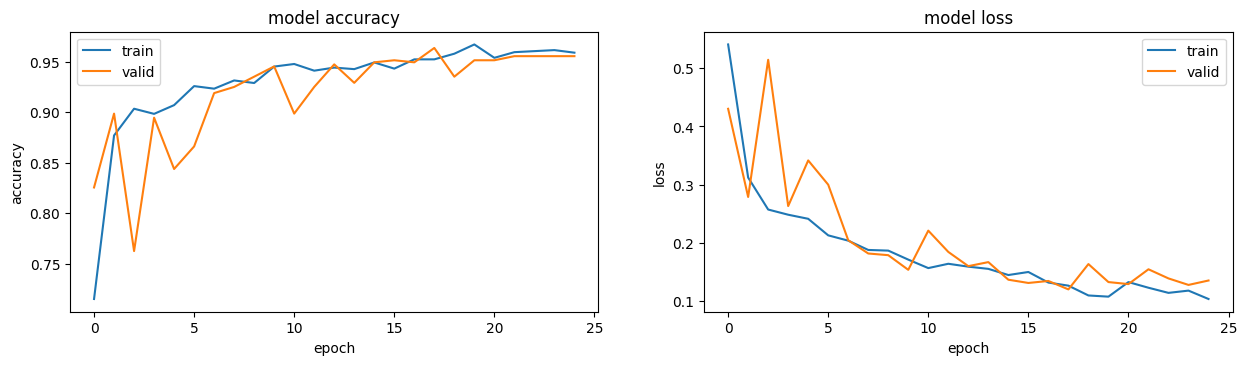

In [ ]:
plt.figure(1, figsize = (15,8))
plt.subplot(221)
plt.plot(hist_df['accuracy'])
plt.plot(hist_df['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.subplot(222)
plt.plot(hist_df['loss'])
plt.plot(hist_df['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

In [ ]:
test_generator.reset()
prediction = model.predict(test_generator)
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator)):
    batch_images, batch_labels = test_generator.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(prediction))

616/616 [==============================] - 33s 51ms/step


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.9626623376623377
0.9621081839570388
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       317
           1       0.98      0.94      0.96       299

    accuracy                           0.96       616
   macro avg       0.96      0.96      0.96       616
weighted avg       0.96      0.96      0.96       616



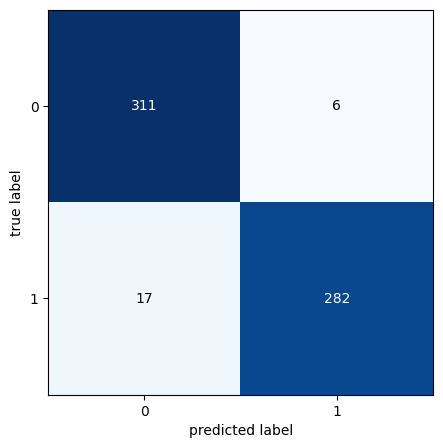

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
predicted_class_indices = np.round(predicted_class_indices)
y_test = labels
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))
plt.show()

In [ ]:
model_save_path = '/content/drive/My Drive/your_folder/"ori_one_fold_new_transfer_09_20.h5"'
model.save(model_save_path)

165/165 [==============================] - 5s 33ms/step
(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.6
0.5932539682539683
              precision    recall  f1-score   support

           0       0.56      0.96      0.71        84
           1       0.86      0.22      0.35        81

    accuracy                           0.60       165
   macro avg       0.71      0.59      0.53       165
weighted avg       0.71      0.60      0.53       165



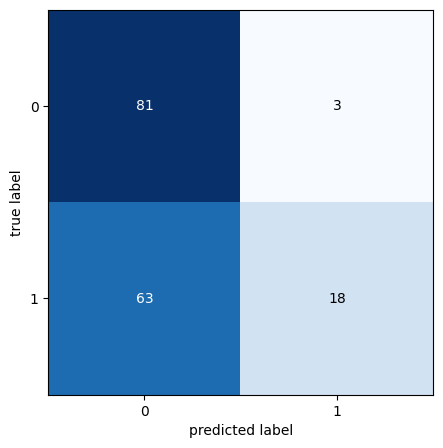

In [ ]:
train_generator_test.reset()
valid_generator_test.reset()
test_generator_test.reset()
combined_prediction = []
combined_prediction.extend(model.predict(test_generator_test))
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator_test)):
    batch_images, batch_labels = test_generator_test.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(combined_prediction))
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
y_test = labels.T
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))

# New Transfer Learning 0.9 Iterations = 20

In [ ]:
valid_generator.reset()

In [ ]:
img_size = 224
dropout_prob = 0.9
weights = "DenseNet_224_up_uncrop.h5"
iterations = 20

In [ ]:
class CustomDropout(Layer):
    def __init__(self, dropout_prob,weights = None):
        super(CustomDropout, self).__init__()
        self.dropout_prob = dropout_prob
        self.masks = None

    def call(self, train_inputs, training=False):
        if training:
          if self.masks is not None:
            modified_object = train_inputs * self.masks
            modified_tensor = tf.convert_to_tensor(modified_object)
            return modified_tensor
        return train_inputs

In [ ]:
base_model = DenseNet121(weights=None, include_top=False,
                                 input_shape = (img_size,img_size,3))
x = base_model.output
globa = layers.GlobalAveragePooling2D()
x = globa(x)
dropout = CustomDropout(dropout_prob)
x = dropout(x)
predictions = layers.Dense(1, activation='sigmoid', name='last')
model = Model(inputs=base_model.input, outputs=predictions(x))
model.load_weights(weights)
num_layers_to_freeze = 300  # You can adjust this fraction as needed
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = False
x = base_model.output
globa = layers.GlobalAveragePooling2D()
x = globa(x)
dropout_one = CustomDropout(dropout_prob)
x = dropout_one(x)
before_predictions = layers.Dense(128, activation='relu')
x = before_predictions(x)
dropout_two = CustomDropout(dropout_prob)
x = dropout_two(x)
predictions = layers.Dense(1, activation='sigmoid', name='last')
model = Model(inputs=base_model.input, outputs=predictions(x))

In [ ]:
import tensorflow.keras.backend as K
print("Compiling the model...")
def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[0] ** (1 - y_true)) * (weights[1] ** y_true) * K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss
opt = Adam(lr=1e-5)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy","AUC","Precision","Recall"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

Compiling the model...


In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_4 (ZeroPadd  (None, 230, 230, 3)          0         ['input_3[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_4[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 3)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [ ]:
num_batches_to_consider = len(valid_generator)
num_batches_to_consider

8

In [ ]:
def custom_random_binomial(random_values,shape, prob, object_to_modify):
    random_values = np.broadcast_to(random_values, shape)
    mask = (random_values < (1-prob)).astype(np.float32)
    modified_object = object_to_modify * mask
    modified_tensor = tf.convert_to_tensor(modified_object)
    return modified_tensor,mask

In [ ]:
def custom_valid_generator(generator, subset_indices):
    max_index = max(subset_indices, default=-1)
    for i, (x, y) in enumerate(generator):
        if i <= max_index:
            yield (x, y)
        else:
            return

In [ ]:
# train the head of the network
def calculate_metric(test_y, test_preds, metric):
  if metric == "auc":
    try:
      # auc = roc_auc_score(test_y.numpy(), np.argmax(test_preds.numpy(), axis=1))
      auc = roc_auc_score(test_y.numpy(),test_preds.numpy())
      return auc
    except:
      return 0.0
    else:
      raise ValueError("Unsupported metric: " + metric)
print("training the head...")
hist_df_list = []
epochs = 25
dropout = [dropout_one,dropout_two]
for i in range(epochs):
  print(f"Epochs {i+1}")
  best_dropout_score = float("-inf")
  weight_best = None
  if dropout_prob < 0 or dropout_prob > 1:
    raise ValueError('Dropout probability has to be between 0 and 1, but got ' + str(dropout_prob))
  for iteration in range(iterations):
    np.random.seed((i+1) * iterations)
    # dropout_layer = tf.keras.layers.Dropout(dropout_prob)
    vbatch_images_array = []
    vbatch_labels_array = []
    for v_step in range(num_batches_to_consider):
      vbatch_images, vbatch_labels = valid_generator[v_step]
      vbatch_images_array.append(vbatch_images)
      vbatch_labels_array.append(vbatch_labels)
    vbatch_images = np.concatenate(vbatch_images_array)
    vbatch_labels = np.concatenate(vbatch_labels_array)

    output = globa(base_model(vbatch_images))
    shape = output.shape
    random_values_one = np.random.random(shape)[0]
    non_mask_one,mask_numpy_one = custom_random_binomial(random_values_one,shape,dropout_prob,output)
    output = before_predictions(non_mask_one)
    shape = output.shape
    random_values_two = np.random.random(shape)[0]
    non_mask_two,mask_numpy_two = custom_random_binomial(random_values_two,shape,dropout_prob,output)
    dropout_score = calculate_metric(vbatch_labels,predictions(non_mask_two),"auc")
    if dropout_score > best_dropout_score:
      best_dropout_score = dropout_score
      weight_best_one = random_values_one
      weight_best_two = random_values_two
  if weight_best is not None:
    dropout[0].masks = weight_best_one
    dropout[1].masks = weight_best_two
  model.compile(loss='binary_crossentropy', optimizer="RMSprop", metrics=["accuracy","AUC","Precision","Recall"])
  history = model.fit(
          train_generator,
          epochs = 1,
          validation_data=valid_generator,
          callbacks=[cb_checkpointer,learning_rate_reduction,cb_early_stopper],
   )
  epoch_hist_df = pd.DataFrame(history.history)
  hist_df_list.append(epoch_hist_df)

# convert the history.history dict to a pandas DataFrame:
hist_df = pd.concat(hist_df_list, ignore_index=True)

training the head...
Epochs 1
31/31 [==============================] - 53s 1s/step - loss: 0.5569 - accuracy: 0.7168 - auc: 0.7873 - precision: 0.7192 - recall: 0.6838 - val_loss: 0.4133 - val_accuracy: 0.8580 - val_auc: 0.9519 - val_precision: 0.8007 - val_recall: 0.9414 - lr: 0.0010
Epochs 2
31/31 [==============================] - 62s 1s/step - loss: 0.3245 - accuracy: 0.8643 - auc: 0.9354 - precision: 0.8707 - recall: 0.8461 - val_loss: 0.7028 - val_accuracy: 0.6511 - val_auc: 0.9589 - val_precision: 0.9855 - val_recall: 0.2845 - lr: 0.0010
Epochs 3
31/31 [==============================] - 53s 1s/step - loss: 0.2616 - accuracy: 0.9034 - auc: 0.9570 - precision: 0.9039 - recall: 0.8963 - val_loss: 0.4519 - val_accuracy: 0.7870 - val_auc: 0.9656 - val_precision: 0.9718 - val_recall: 0.5774 - lr: 0.0010
Epochs 4
31/31 [==============================] - 51s 1s/step - loss: 0.2473 - accuracy: 0.9080 - auc: 0.9612 - precision: 0.9135 - recall: 0.8953 - val_loss: 0.3917 - val_accuracy: 0.

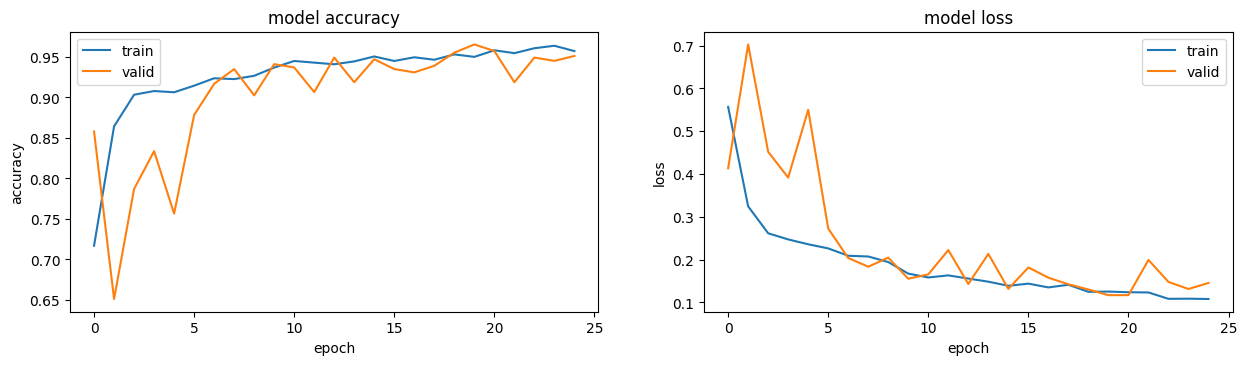

In [ ]:
plt.figure(1, figsize = (15,8))
plt.subplot(221)
plt.plot(hist_df['accuracy'])
plt.plot(hist_df['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.subplot(222)
plt.plot(hist_df['loss'])
plt.plot(hist_df['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

In [ ]:
test_generator.reset()
prediction = model.predict(test_generator)
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator)):
    batch_images, batch_labels = test_generator.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(prediction))

616/616 [==============================] - 20s 28ms/step


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.9561688311688312
0.9552293132734773
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       317
           1       0.99      0.92      0.95       299

    accuracy                           0.96       616
   macro avg       0.96      0.96      0.96       616
weighted avg       0.96      0.96      0.96       616



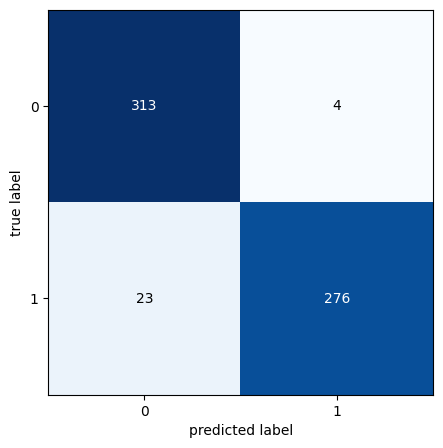

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
predicted_class_indices = np.round(predicted_class_indices)
y_test = labels
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))
plt.show()

In [ ]:
model_save_path = '/content/drive/My Drive/your_folder/"ori_one_fold_new_transfer_09_20.h5"'
model.save(model_save_path)

165/165 [==============================] - 5s 29ms/step
(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.6060606060606061
0.599647266313933
              precision    recall  f1-score   support

           0       0.57      0.95      0.71        84
           1       0.83      0.25      0.38        81

    accuracy                           0.61       165
   macro avg       0.70      0.60      0.55       165
weighted avg       0.70      0.61      0.55       165



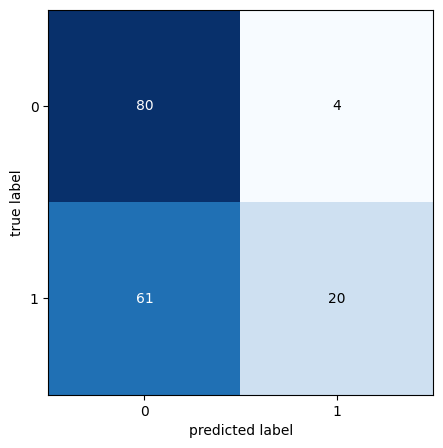

In [ ]:
train_generator_test.reset()
valid_generator_test.reset()
test_generator_test.reset()
combined_prediction = []
combined_prediction.extend(model.predict(test_generator_test))
images = []
labels = []
predicted_class_indices = []
for i in range(len(test_generator_test)):
    batch_images, batch_labels = test_generator_test.next()
    images.extend(batch_images)
    labels.extend(batch_labels)
images = np.array(images)
labels = np.array(labels)
predicted_class_indices = np.round(np.array(combined_prediction))
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, classification_report
y_test = labels.T
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(roc_auc_score(y_test, predicted_class_indices, multi_class='ovr'))
print(classification_report(y_test, predicted_class_indices))